In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import chardet
from sklearn.metrics import pairwise_distances, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import hdbscan
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skfuzzy.cluster import cmeans

In [2]:
# Here im writin a function to detect the encoding
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
    return result['encoding'], result['confidence']

# Here Im setting the pathnames
movies_path = "/Users/jason/Desktop/MLB_CA2/movies.csv"
rating_path = "/Users/jason/Desktop/MLB_CA2/ratings.csv"
tags_path = "/Users/jason/Desktop/MLB_CA2/tags.csv"

# Detecting and running through movies
movies_encoding, movies_confidence = detect_encoding(movies_path)
print(f"Detected encoding for movies.csv: {movies_encoding}, Confidence: {movies_confidence}")
movies = pd.read_csv(movies_path, encoding=movies_encoding)
print("Movies DataFrame:")
print(movies.head())

# Then for ratings
rating = pd.read_csv(rating_path)
print("\nRating DataFrame:")
print(rating.head())

# aND then for tags too finally
tags_encoding, tags_confidence = detect_encoding(tags_path)
print(f"\nDetected encoding for tags.csv: {tags_encoding}, Confidence: {tags_confidence}")

try:
    tags = pd.read_csv(tags_path, encoding=tags_encoding, engine='python', on_bad_lines='skip')
    print("\nTags DataFrame:")
    print(tags.head())
except UnicodeDecodeError as e:
    print(f"UnicodeDecodeError for tags.csv: {e}")
    tags = pd.read_csv(tags_path, encoding=tags_encoding, engine='python', errors='ignore')
    print("\nTags DataFrame (with errors ignored):")
    print(tags.head())

Detected encoding for movies.csv: ISO-8859-1, Confidence: 0.73
Movies DataFrame:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Rating DataFrame:
   userId  movieId  rating   timestamp
0   12882        1     4.0  1147195252
1   12882       32     3.5  1147195307
2   12882       47     5.0  1147195343
3   12882       50     5.0  1147185499
4   12882      110     4.5  1147195239

Detected encoding for tags.csv: Windows-1252, Confidence: 0.7287846055

Have to merge these sequentially

In [3]:
df = pd.merge(movies, rating, on="movieId")
df = pd.merge(df, tags, on="movieId")
df.head()

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12882,4.0,1147195252,108922,children,1284588869
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12882,4.0,1147195252,108922,computer animation,1284588868
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12882,4.0,1147195252,108922,Disney,1284588860
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12882,4.0,1147195252,108922,family,1284588873
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12882,4.0,1147195252,108922,Pixar,1284588865


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17959891 entries, 0 to 17959890
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   movieId      int64  
 1   title        object 
 2   genres       object 
 3   userId_x     int64  
 4   rating       float64
 5   timestamp_x  int64  
 6   userId_y     int64  
 7   tag          object 
 8   timestamp_y  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 1.2+ GB


In [ ]:
df.isna().sum()

movieId        0
title          0
genres         0
userId_x       0
rating         0
timestamp_x    0
userId_y       0
tag            0
timestamp_y    0
dtype: int64

In [ ]:
df.duplicated().any()

False

## Collaborative Filtering

In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
print(f"Train set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

Train set shape: (14367912, 9)
Test set shape: (3591979, 9)


Here im prepping the data by filtering the ratings, identifying the active users, finding the average ratings, combining them and calulating out the aadjusted ratings

In [ ]:
ratings = train_data[train_data["rating"] > 0]
ratings.groupby("userId_x").count()["movieId"] > 200
user_mean_rating = ratings.groupby(by="userId_x")['rating'].mean()
ratings = pd.merge(ratings, user_mean_rating, on="userId_x")
ratings["Adjusted-Rating"] = ratings["rating_x"] - ratings["rating_y"]

Here im transforming the data into a user item matrix where rows represent users and columns are movies with the values being the adjusted ratings. Any missing values are then filled in with the users average adjusted rating to make sure the matrix is complete and ready for siimilarity calculations or further analysis

In [ ]:
adjusted_user_ratings = pd.pivot_table(ratings, values="Adjusted-Rating", index="userId_x", columns="movieId")
final_user = adjusted_user_ratings.apply(lambda row: row.fillna(row.mean()), axis=1)

Im calculating the cosine similarity between users based on their adjusted ratings. The diagonal o the similarity matrix is set to zero to exclude self similarity. Finally the similarity matrix is stored as a df where rows and columns represent users and the values indicate the similarity scores between them.

In [ ]:
b = cosine_similarity(final_user)
np.fill_diagonal(b, 0)
similarity_with_user = pd.DataFrame(b, index=final_user.index)
similarity_with_user.columns = final_user.index

This step finds the top N most similar users for each user by sorting similarity scores and storing the top N indices in a df

In [ ]:
def find_n_neighbours(similarity_matrix, n):
    order = np.argsort(similarity_matrix.values, axis=1)[:, -n:]
    return similarity_matrix.apply(
        lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                            index=[f"top{i}" for i in range(1, n + 1)]),
        axis=1
    )

is retrieves and displays the top 30 most similar users for each user based on their similarity scores

In [ ]:
sim_user_30_u = find_n_neighbours(similarity_with_user,30)
sim_user_30_u.head()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,...,top21,top22,top23,top24,top25,top26,top27,top28,top29,top30
userId_x,,,,,,,,,,,,,,,,,,,,,
316,88932,24802,5268,96936,93347,138176,8335,54643,12721,27142,...,125207,96977,38187,114335,17194,65255,134196,13927,1447,137609
320,93347,96936,138176,8335,51255,61400,54643,5268,27142,17194,...,124981,22245,121403,137609,96977,109692,38256,134196,24802,65255
359,102118,50898,96482,60016,120782,32780,57474,35246,102532,134181,...,67352,79846,137559,65670,38159,2702,117258,53877,81998,1738
370,40768,113645,24802,1738,86309,137559,44194,117007,51460,60016,...,54643,93203,45120,8335,123707,96936,102549,96977,101004,132578
910,87042,131620,31321,48821,67352,40768,63295,84752,26222,370,...,108195,134521,70201,58265,114601,23428,17039,97195,133811,10387


Finds movies that two users have both rated, combining their ratings with movie details for comparison

In [ ]:
def get_user_similar_items( user1, user2 ):
    df = ratings.reset_index()
    common_items = df[df["userId_x"] == user1].merge(
    df[df["userId_x"] == user2],
    on = "movieId",
    how = "inner" )
    return common_items.merge( movies, on = 'movieId' )

In [ ]:
a = get_user_similar_items(370, 40768)
common_items = a
a = a.loc[ : , ['rating_x_x','rating_x_y', 'rating_y_y', 'rating_y_x', 'movieId', "genres_x"]]
a = a.drop_duplicates()
a = a.sort_values(by="rating_x_y", ascending=False)
a

,rating_x_x,rating_x_y,rating_y_y,rating_y_x,movieId,genres_x
47691,5.0,5.0,3.955198,3.987979,2324,Comedy|Drama|Romance|War
33172,5.0,5.0,3.955198,3.987979,858,Crime|Drama
19189,4.5,5.0,3.955198,3.987979,1219,Crime|Horror
0,5.0,4.5,3.955198,3.987979,296,Comedy|Crime|Drama|Thriller
9464,5.0,4.5,3.955198,3.987979,5952,Adventure|Fantasy
...,...,...,...,...,...,...
34994,1.5,2.5,3.955198,3.987979,5502,Horror|Sci-Fi|Thriller
34212,1.0,2.0,3.955198,3.987979,1391,Action|Comedy|Sci-Fi
3979,3.5,2.0,3.955198,3.987979,5378,Action|Adventure|Sci-Fi|IMAX
46874,2.5,2.0,3.955198,3.987979,53996,Action|Sci-Fi|Thriller|IMAX


In [ ]:
user1_actual = a['rating_x_x']
user1_predicted = a['rating_x_y']
mae = np.mean(np.abs(user1_actual - user1_predicted))
rmse = np.sqrt(np.mean((user1_actual - user1_predicted) ** 2))
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

MAE: 0.7911, RMSE: 1.0806


Here I'm generating my recommendations for the test users with a new function

In [ ]:
def generate_user_recommendations(test_users, similarity_with_user, k=10):
    recommendations = {}

    for user in test_users:
        if user in similarity_with_user.index:
            # Here Im finding the most similar user and using my function
            most_similar_user = similarity_with_user.loc[user].idxmax()
            similar_items = get_user_similar_items(user, most_similar_user)

            # Here then i am sorting items by the similar users ratings and taking the top K
            recommended_items = similar_items.sort_values(by='rating_x_y', ascending=False)['movieId'].tolist()[:k]
            recommendations[user] = recommended_items
        else:
            recommendations[user] = []
    return recommendations

# Generate recommendations for test users and evaluating for Precision and Recall
test_users = test_data['userId_x'].unique()
user_recommendations = generate_user_recommendations(test_users, similarity_with_user, k=10)

precision_k, recall_k = precision_recall_at_k(test_data, user_recommendations, k=10)
print(f"Precision@10: {precision_k:.4f}, Recall@10: {recall_k:.4f}")

Precision@10: 0.1451, Recall@10: 0.0006


In [ ]:
def precision_recall_at_k(test_data, user_recommendations, k=10):
    precisions = []
    recalls = []

    for user in test_data['userId_x'].unique():
        # Actual items for the user in the test data, recojmmend items and calulare the precision and recall
        actual_items = test_data[test_data['userId_x'] == user]['movieId'].tolist()

        recommended_items = user_recommendations.get(user, [])[:k]

        relevant_and_recommended = len(set(recommended_items) & set(actual_items))
        precision = relevant_and_recommended / k if k > 0 else 0
        recall = relevant_and_recommended / len(actual_items) if actual_items else 0

        precisions.append(precision)
        recalls.append(recall)

    # Here Im returning the average precision and recall across all users
    return np.mean(precisions), np.mean(recalls)

# Then finally get recommendations for test users and evaluating for precision and recall
test_users = test_data['userId_x'].unique()
user_recommendations = generate_user_recommendations(test_users, similarity_with_user, k=10)

precision_k, recall_k = precision_recall_at_k(test_data, user_recommendations, k=10)
print(f"Precision@10: {precision_k:.4f}, Recall@10: {recall_k:.4f}")

Precision@10: 0.1451, Recall@10: 0.0006


# Content based filtering

In [ ]:
#function the bootstrap sampling
def bootstrap_sample(df, n_samples=10000, random_state=0):
    return df.sample(n=n_samples, replace=True, random_state=random_state)

# Create a sample
bootstrap_df = bootstrap_sample(df, n_samples=10000, random_state=0)
print(f"Bootstrap Sample Shape: {bootstrap_df.shape}")

# Train test splt on the sample
train_data, test_data = train_test_split(bootstrap_df, test_size=0.2, random_state=0)
print(f"Train set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Combine features for the train set
train_data["combined_features"] = train_data["title"] + " " + train_data["genres"]

# Vectorize those features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(train_data["combined_features"])
print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")

# Then compute sparse cosine similarity
cosine_sim_sparse = cosine_similarity(tfidf_matrix, dense_output=False)
print(f"Sparse Cosine Similarity Matrix Shape: {cosine_sim_sparse.shape}")

Bootstrap Sample Shape: (10000, 9)
Train set shape: (8000, 9)
Test set shape: (2000, 9)
TF-IDF Matrix Shape: (8000, 2186)
Sparse Cosine Similarity Matrix Shape: (8000, 8000)


In [ ]:
movie_to_index = {movie_id: idx for idx, movie_id in enumerate(train_data['movieId'])}
def recommend_similar_items(item_id, top_n=10):

    if item_id not in movie_to_index:
        return []
    idx = movie_to_index[item_id]
    similarity_scores = list(enumerate(cosine_sim_sparse[idx].toarray().flatten()))
    sorted_similar_items = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    recommended_ids = []
    seen_ids = set()
    for item_idx, score in sorted_similar_items[1:]:
        movie_id = train_data.iloc[item_idx]['movieId']
        if movie_id not in seen_ids:
            seen_ids.add(movie_id)
            recommended_ids.append(movie_id)
        if len(recommended_ids) == top_n:
            break
    return recommended_ids

def precision_recall_at_k(test_data, k=10):
    precisions = []
    recalls = []
    for user in test_data['userId_x'].unique():
        actual_items = test_data[test_data['userId_x'] == user]['movieId'].tolist()
        recommended_items = []
        for item_id in actual_items:
            recommendations = recommend_similar_items(item_id, top_n=k)
            recommended_items += recommendations
        recommended_items = list(set(recommended_items))
        relevant_and_recommended = len(set(recommended_items) & set(actual_items))
        precision = relevant_and_recommended / k if k > 0 else 0
        recall = relevant_and_recommended / len(actual_items) if actual_items else 0
        precisions.append(precision)
        recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)

precision_k, recall_k = precision_recall_at_k(test_data, k=10)
print(f"Precision@10: {precision_k:.4f}, Recall@10: {recall_k:.4f}")

Precision@10: 0.2770, Recall@10: 0.8954


Here is the recommender to Plug your queries into

In [ ]:
recommend_similar_items(item_id=1, top_n=10)

Recommendations for Movie ID 1:
1: Toy Story (1995) (Movie ID: 1)
2: Toy Story 2 (1999) (Movie ID: 3114)
3: Toy Story 3 (2010) (Movie ID: 78499)
4: NeverEnding Story, The (1984) (Movie ID: 2161)
5: Christmas Story, A (1983) (Movie ID: 2804)
6: Shrek (2001) (Movie ID: 4306)
7: Jumanji (1995) (Movie ID: 2)
8: Antz (1998) (Movie ID: 2294)
9: Shrek the Third (2007) (Movie ID: 53121)
10: Goofy Movie, A (1995) (Movie ID: 239)


# Clustering

## PCA

Here Im label encoding my categorical columns, then running PCA on it before visualising that with the elbow method on 95% variance and then running my data on the results (9 component).

In [4]:
label_encoded_df = df.copy()
categorical_columns = df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    label_encoded_df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

data_scaled = StandardScaler().fit_transform(label_encoded_df)
pca = PCA()
pca.fit(data_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

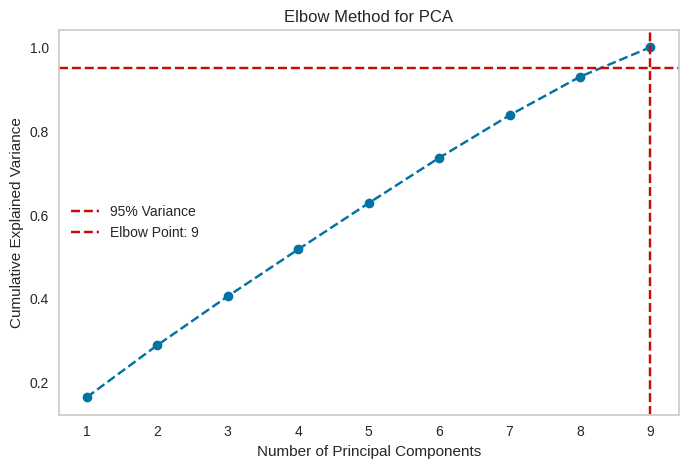

Number of components to retain 95% variance: 9


In [5]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.grid()

threshold = 0.95
elbow_point = np.argmax(cumulative_variance >= threshold) + 1
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100:.0f}% Variance')
plt.axvline(x=elbow_point, color='r', linestyle='--', label=f'Elbow Point: {elbow_point}')
plt.legend()
plt.show()

print(f"Number of components to retain {threshold*100:.0f}% variance: {elbow_point}")

In [5]:
pca = PCA(n_components=9)
reduced_data = pca.fit_transform(data_scaled)

## KNN

Here I am taking a sample of 1 mill rows and keeping the seed, before running elbow method and coresponing visual.

In [6]:
sample_size = 1000000
np.random.seed(0)
X_sample = np.random.choice(reduced_data.shape[0], sample_size, replace=False)
reduced_data_df = pd.DataFrame(reduced_data)
subset_data = reduced_data_df.iloc[X_sample]

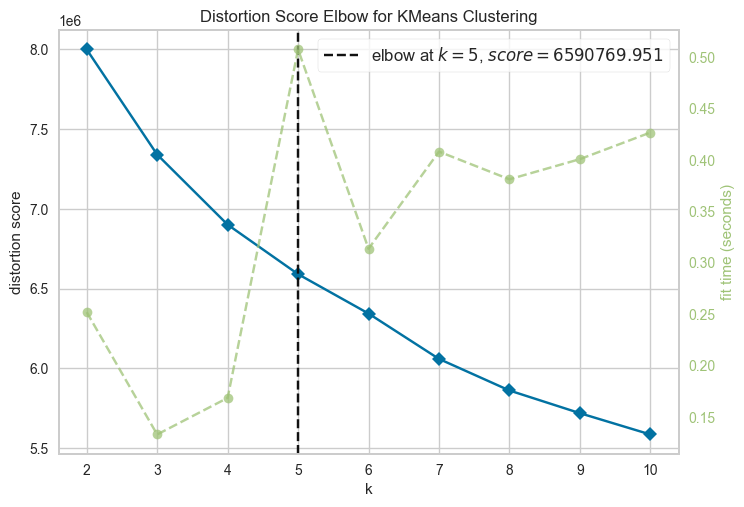

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
Elbow_M = KElbowVisualizer(KMeans(random_state=0), k=10)
Elbow_M.fit(subset_data)
Elbow_M.show()

In [8]:
kmeans = KMeans(n_clusters=5, random_state=0)
subset_indices = subset_data.index
cluster_labels = kmeans.fit_predict(subset_data)

In [26]:
subset_data

,0,1,2,3,4,5,6,7,8
2626920,0.185548,0.307290,-0.148581,0.117484,-1.370807,0.060323,1.288505,-1.120254,-1.056300
5286052,-1.724524,-0.129253,-1.725796,-1.195000,0.029338,-0.943612,-1.334985,0.257946,0.264716
13405543,-0.224205,1.085075,0.411450,-1.196382,-1.067728,-0.911524,0.214097,0.047133,-0.185407
15060974,1.286362,0.739325,1.198745,0.949120,-0.536683,0.421234,0.588221,-0.528109,1.005620
8801706,-0.153280,-0.404884,-0.981342,0.027899,0.783893,-0.496587,-1.064953,1.057881,-0.800563
...,...,...,...,...,...,...,...,...,...
14119570,1.265326,-0.678024,-1.206289,1.397717,0.857640,1.501358,-0.129951,-0.120104,-0.205460
10172248,0.456333,1.099011,-0.817789,0.138254,0.747578,0.373523,1.430247,-0.576407,-1.062440
12909228,0.511013,-0.269779,-2.501438,0.178698,-0.970817,0.237839,-1.760095,-0.845329,-1.324771
8429040,-1.478655,0.307541,-1.591420,-0.723272,1.576423,-1.118426,-0.916697,0.056847,0.242430


Here I am taking another sub sample of 100k rows to run a silhouette score on

In [29]:
sample_size = 100000
np.random.seed(0)
sampled_indices = np.random.choice(subset_data.shape[0], sample_size, replace=False)
subset_sample = subset_data.iloc[sampled_indices]
cluster_labels_sample = cluster_labels[sampled_indices]

score = silhouette_score(subset_sample, cluster_labels_sample)
print(f"Silhouette Score for the 100k sample: {score}")

Silhouette Score for the 10k sample: 0.09568603661990341


### Cluster Analysis

Here Im creating a clusters column, cleaning it and plotting the distribution.

In [9]:
cluster_labels_series = pd.Series(cluster_labels, index=subset_data.index)
df['cluster'] = df.index.map(cluster_labels_series)

In [10]:
df.cluster.value_counts()

,count
cluster,
3.0,219690
0.0,205931
4.0,205788
1.0,205248
2.0,163343


In [10]:
df_cleaned = df.dropna(subset=['cluster'])

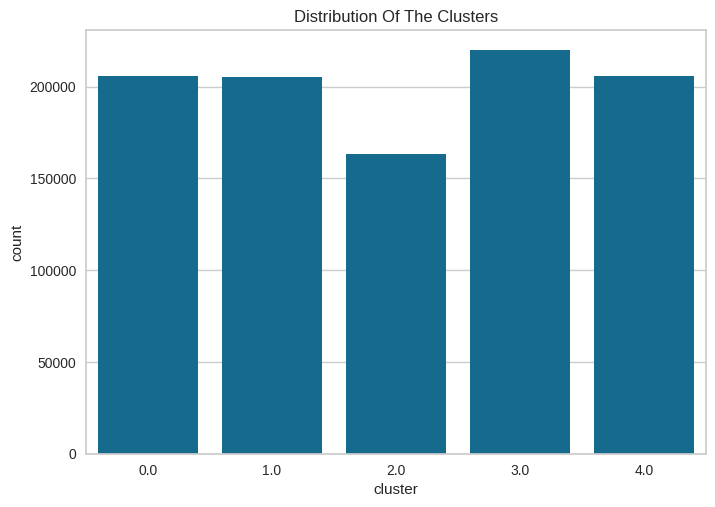

In [31]:
pl = sns.countplot(x=df_cleaned["cluster"])
pl.set_title("Distribution Of The Clusters")
plt.show()

Here Im seperating the values in my genre column by | and exploding it, beofre plotting out a stacked bar chart with tab20 palette

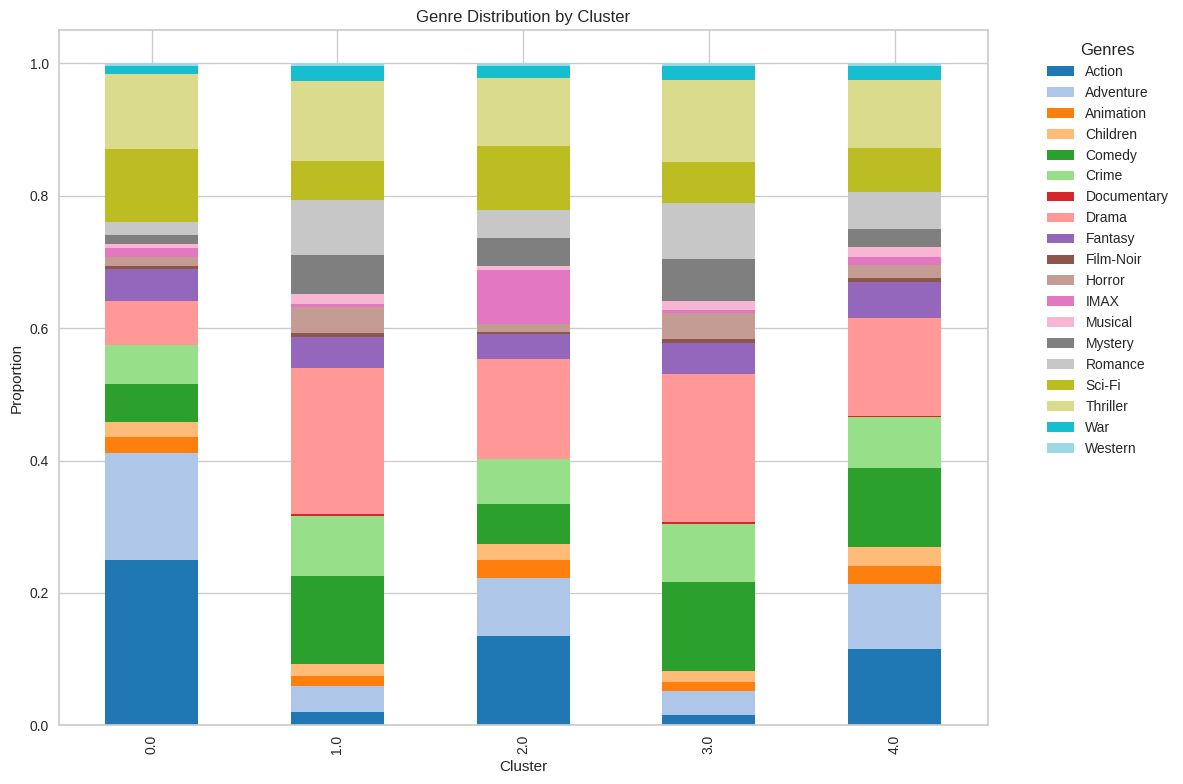

In [11]:
df_exploded = df_cleaned.copy()
df_exploded['genres'] = df_exploded['genres'].str.split('|')
df_exploded = df_exploded.explode('genres')

genre_distribution = df_exploded.groupby(['cluster', 'genres']).size().unstack(fill_value=0)
genre_distribution = genre_distribution.div(genre_distribution.sum(axis=1), axis=0)

genre_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Genre Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Same plot as before pretty much, but just for the three largest genres

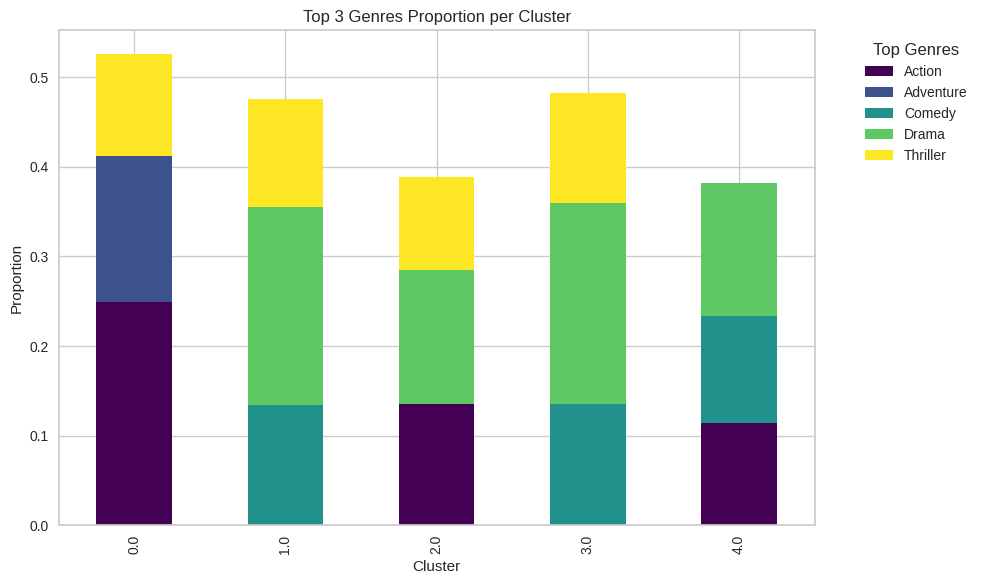

In [15]:
top_genres_proportions = genre_distribution.apply(lambda x: x.nlargest(3), axis=1)

top_genres_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Top 5 Genres Proportion per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Top Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Simple barplot of average ratings which is defined in the beginning

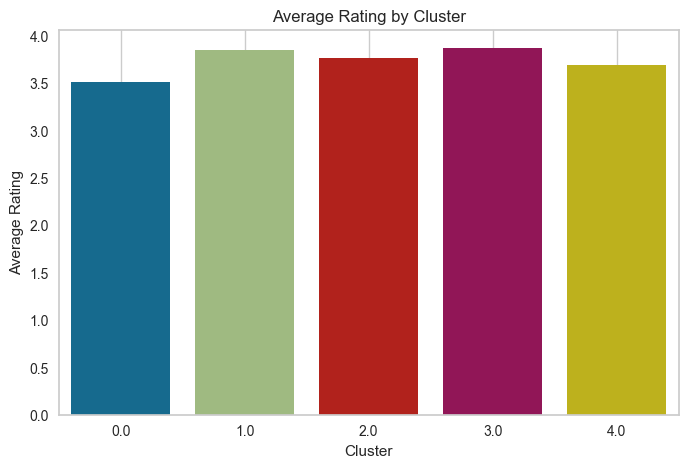

In [ ]:
avg_ratings = df_cleaned.groupby('cluster')['rating'].mean().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=avg_ratings, x='cluster', y='rating')
plt.title("Average Rating by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Rating")
plt.grid()
plt.show()

Here I'm defining the top titles by clusters and plotting it out by the 5 largest in a cluster by count inverted vertically.

<ipython-input-22-5db20a51d1b3>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'count'))


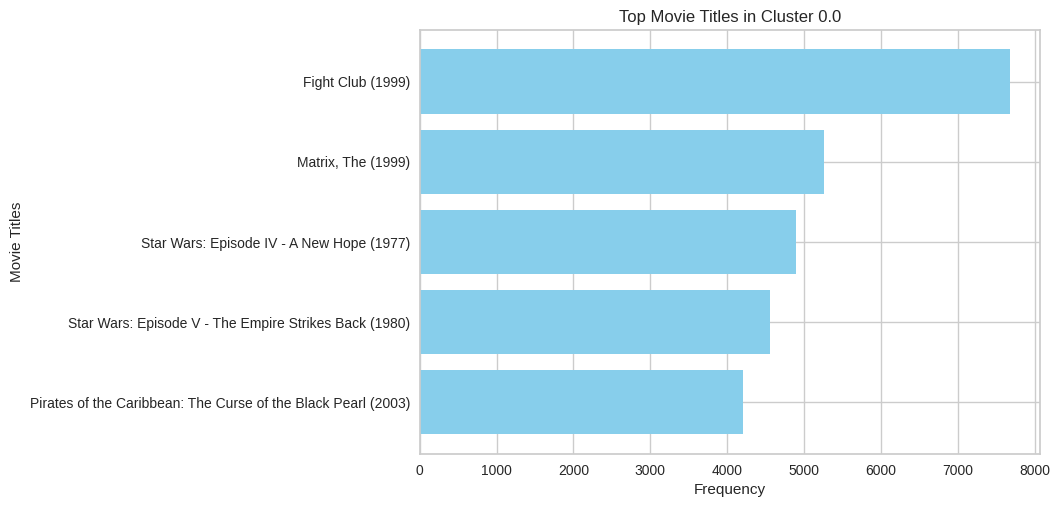

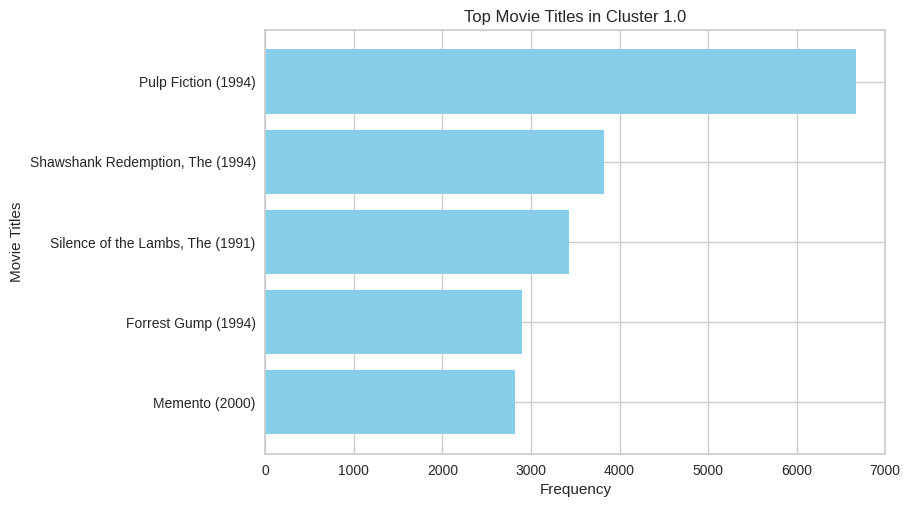

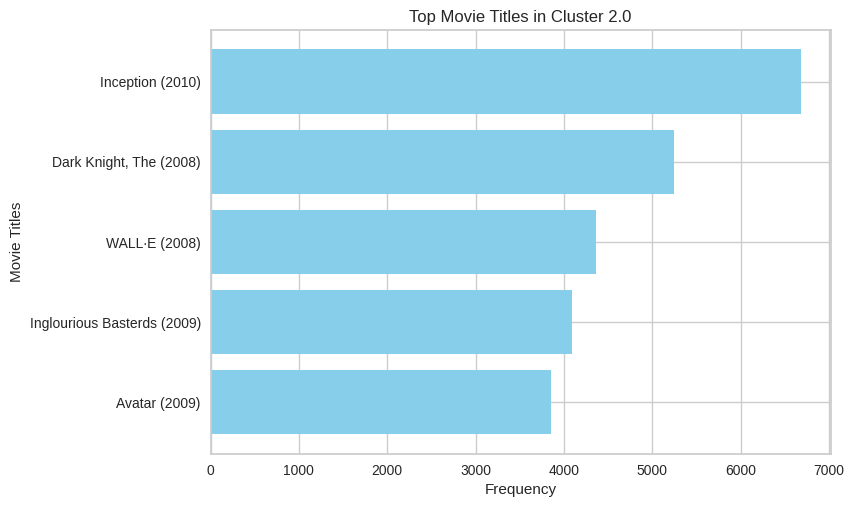

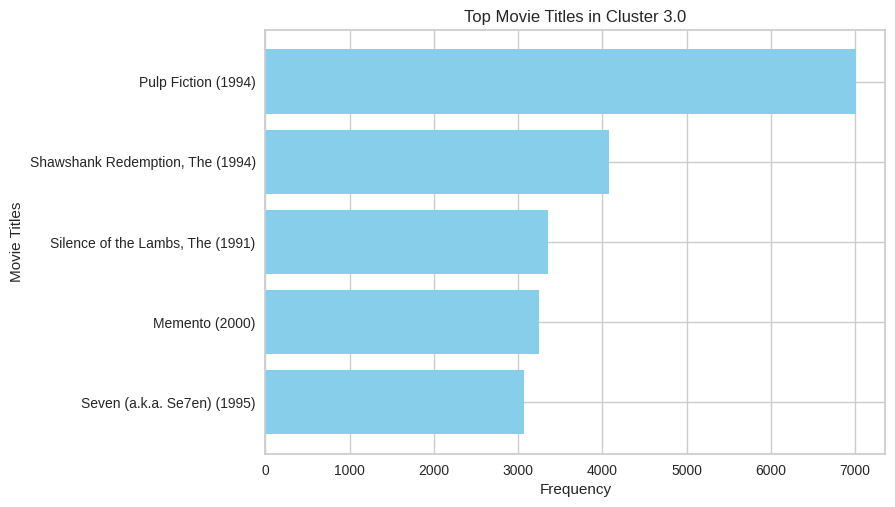

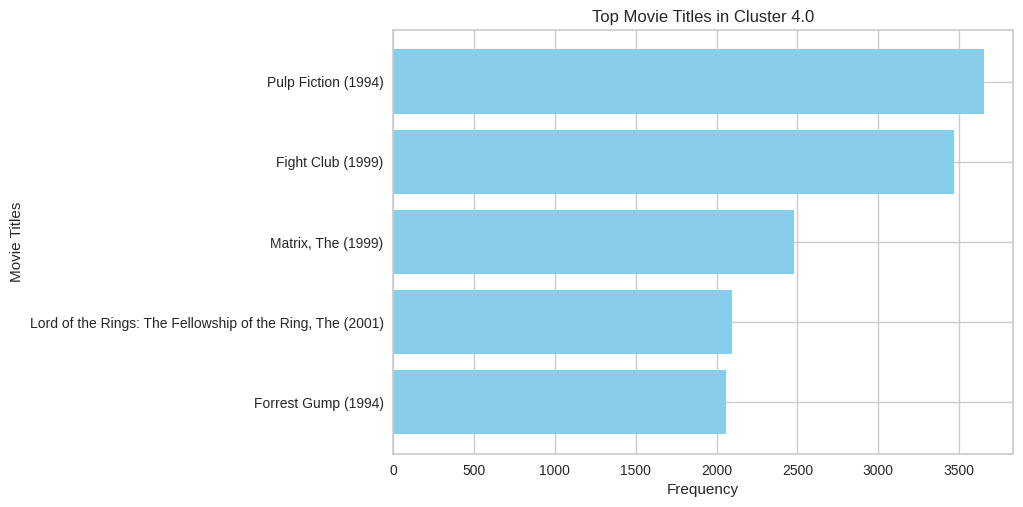

In [22]:
top_titles_by_cluster = df_cleaned.groupby(['cluster', 'title']).size().reset_index(name='count')

top_titles_by_cluster = (
    top_titles_by_cluster.groupby('cluster', group_keys=False)
    .apply(lambda x: x.nlargest(5, 'count'))
)

for cluster in top_titles_by_cluster['cluster'].unique():
    cluster_data = top_titles_by_cluster[top_titles_by_cluster['cluster'] == cluster]
    plt.barh(cluster_data['title'], cluster_data['count'], color='skyblue')

    plt.title(f'Top Movie Titles in Cluster {cluster}')
    plt.xlabel('Frequency')
    plt.ylabel('Movie Titles')
    plt.gca().invert_yaxis()
    plt.show()

Here I'm defining the exploded genres again and plotting out each genre by clister with boxplots

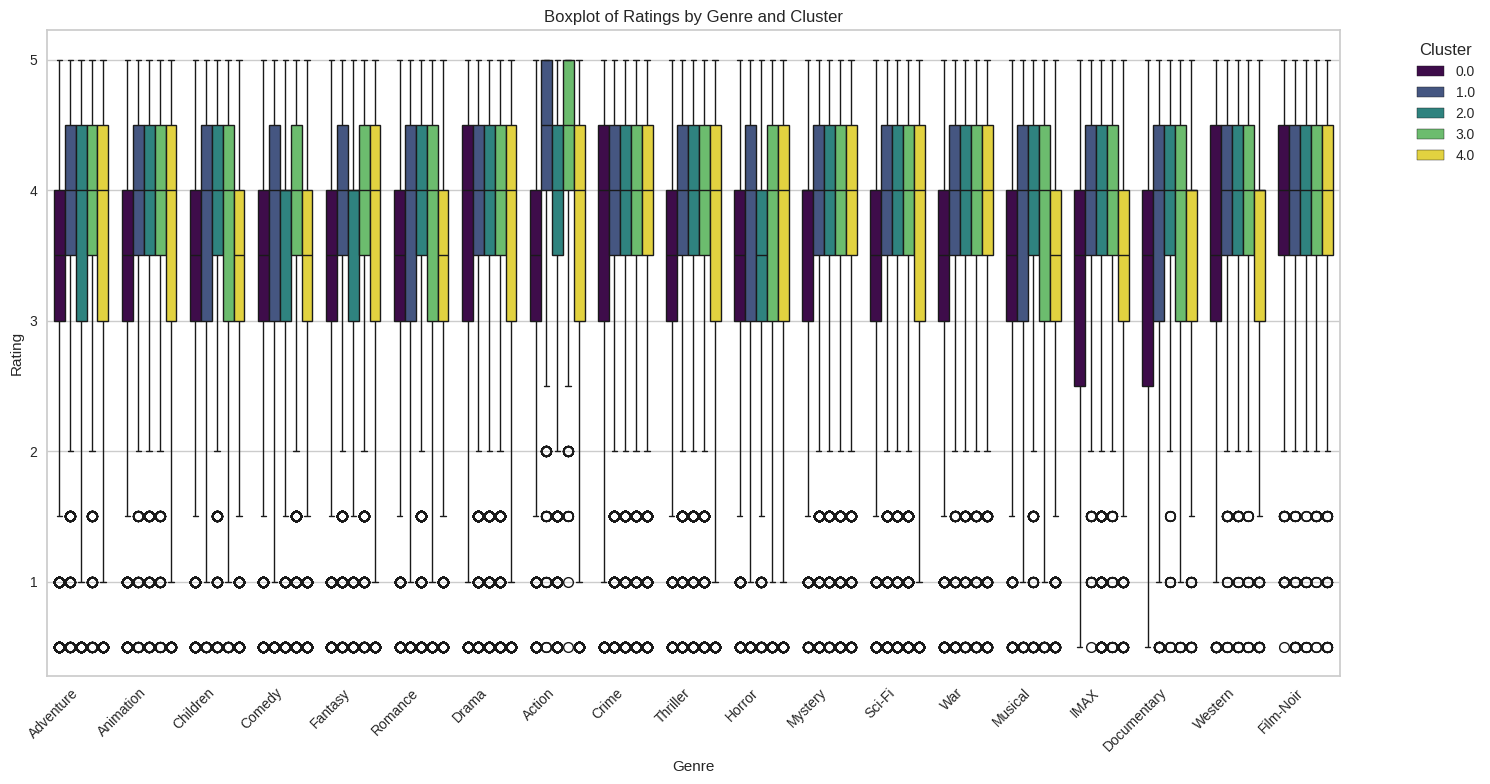

In [24]:
df_exploded = df_cleaned.copy()
df_exploded['genres'] = df_exploded['genres'].str.split('|')  
df_exploded = df_exploded.explode('genres')

plt.figure(figsize=(15, 8))
sns.boxplot(
    x='genres', y='rating', hue='cluster', data=df_exploded, palette='viridis'
)
plt.title('Boxplot of Ratings by Genre and Cluster')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## DBSCAN

The rest largely repeats, so instead of repeating markdowns, I will only add them in for new cells

In [ ]:
sample_size = 1000000
np.random.seed(0)
X_sample = np.random.choice(reduced_data.shape[0], sample_size, replace=False)
subset_data = reduced_data[X_sample]

here I am plotting out the k-distances, which is basically an elbow method for dbscan.

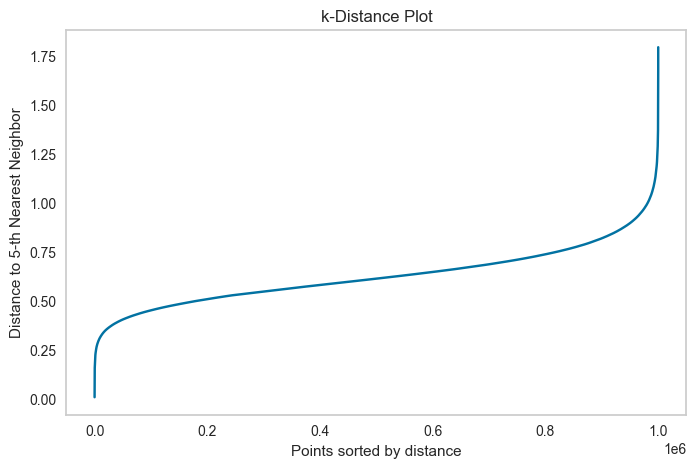

In [ ]:
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(subset_data)
distances, indices = neighbors_fit.kneighbors(subset_data)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title("k-Distance Plot")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.grid()
plt.show()

Here I am running various experiments with different parameter and tracking the results

In [ ]:
eps = 0.5
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(subset_data)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = np.sum(clusters == -1)
print(f"Number of clusters: {unique_clusters}")
print(f"Number of noise points: {noise_points}")

Number of clusters: 17155
Number of noise points: 681005


In [ ]:
eps = 0.48
min_samples = 6
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(subset_data)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = np.sum(clusters == -1)
print(f"Number of clusters: {unique_clusters}")
print(f"Number of noise points: {noise_points}")

Number of clusters: 10848
Number of noise points: 802539


In [ ]:
eps = 0.46
min_samples = 6
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(subset_data)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = np.sum(clusters == -1)
print(f"Number of clusters: {unique_clusters}")
print(f"Number of noise points: {noise_points}")

Number of clusters: 9842
Number of noise points: 847363


In [ ]:
eps = 0.44
min_samples = 6
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(subset_data)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = np.sum(clusters == -1)
print(f"Number of clusters: {unique_clusters}")
print(f"Number of noise points: {noise_points}")

Number of clusters: 8473
Number of noise points: 885433


In [ ]:
eps = 0.44
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(subset_data)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = np.sum(clusters == -1)
print(f"Number of clusters: {unique_clusters}")
print(f"Number of noise points: {noise_points}")

Number of clusters: 14725
Number of noise points: 831018


In [ ]:
eps = 0.4
min_samples = 10
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(subset_data)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
noise_points = np.sum(clusters == -1)
print(f"Number of clusters: {unique_clusters}")
print(f"Number of noise points: {noise_points}")

Number of clusters: 611
Number of noise points: 990121


## HDBSCAN

In [48]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=150, min_samples=10)
clusters_hdbscan = hdbscan_clusterer.fit_predict(subset_data)
unique_clusters = len(set(clusters_hdbscan)) - (1 if -1 in clusters_hdbscan else 0)
noise_points = np.sum(clusters_hdbscan == -1)
print(f"Number of clusters: {unique_clusters}")
print(f"Number of noise points: {noise_points}")

Number of clusters: 6
Number of noise points: 274579


In [49]:
subset_data = pd.DataFrame(subset_data)  
valid_indices = np.where(clusters_hdbscan != -1)[0]
filtered_data = subset_data.iloc[valid_indices]
filtered_labels = clusters_hdbscan[valid_indices]

sample_size = 100000
np.random.seed(0)
sampled_indices = np.random.choice(filtered_data.shape[0], sample_size, replace=False)
subset_sample = filtered_data.iloc[sampled_indices]
cluster_labels_sample = filtered_labels[sampled_indices]

from sklearn.metrics import silhouette_score

score = silhouette_score(subset_sample, cluster_labels_sample)
print(f"Silhouette Score for the 100k sample (HDBSCAN): {score}")

Silhouette Score for the 100k sample (HDBSCAN): -0.1175580196825789


### Cluster Analysis

In [50]:
subset_data_2 = pd.DataFrame(subset_data, columns=[f'PCA_{i+1}' for i in range(subset_data.shape[1])])
subset_data_2['cluster'] = clusters_hdbscan

In [51]:
df_sampled = df.iloc[X_sample].copy()
df_sampled['cluster'] = clusters_hdbscan

In [52]:
cluster_counts = df_sampled['cluster'].value_counts()
cluster_counts = cluster_counts[cluster_counts.index != -1]
top_10_clusters = cluster_counts.head(10)
print("Top 10 clusters (excluding noise):\n", top_10_clusters)
top_10_cluster_names = top_10_clusters.index.tolist()
print("Cluster labels for the top 10 clusters:", top_10_cluster_names)

Top 10 clusters (excluding noise):
 cluster
0    635028
5     89344
4       389
3       324
1       181
2       155
Name: count, dtype: int64
Cluster labels for the top 10 clusters: [0, 5, 4, 3, 1, 2]


Cluster sizes:
 cluster
0    635028
5     89344
4       389
3       324
1       181
2       155
Name: count, dtype: int64


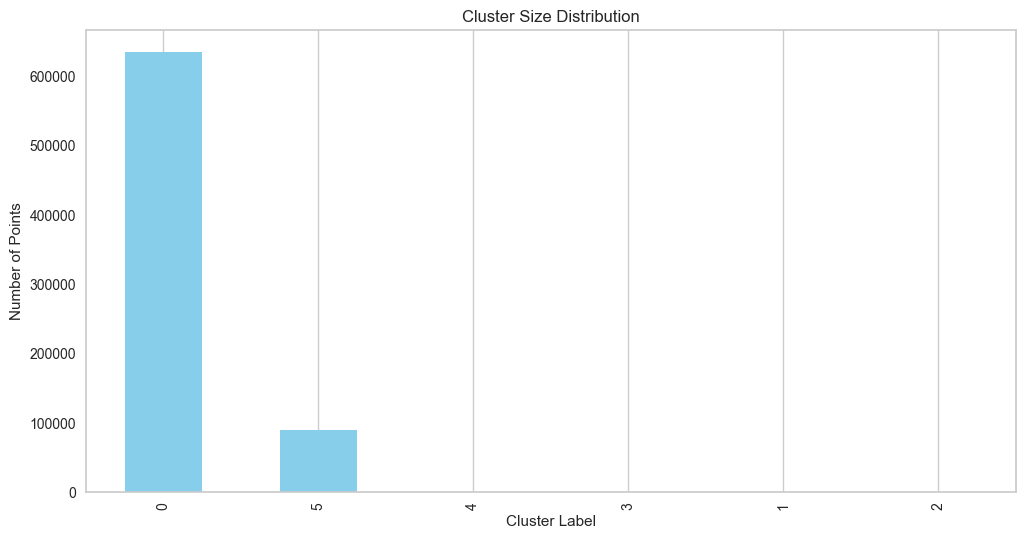

In [58]:
cluster_counts = df_sampled['cluster'].value_counts()
cluster_counts = cluster_counts[cluster_counts.index != -1]  

print("Cluster sizes:\n", cluster_counts)
cluster_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.grid(axis='y')
plt.show()

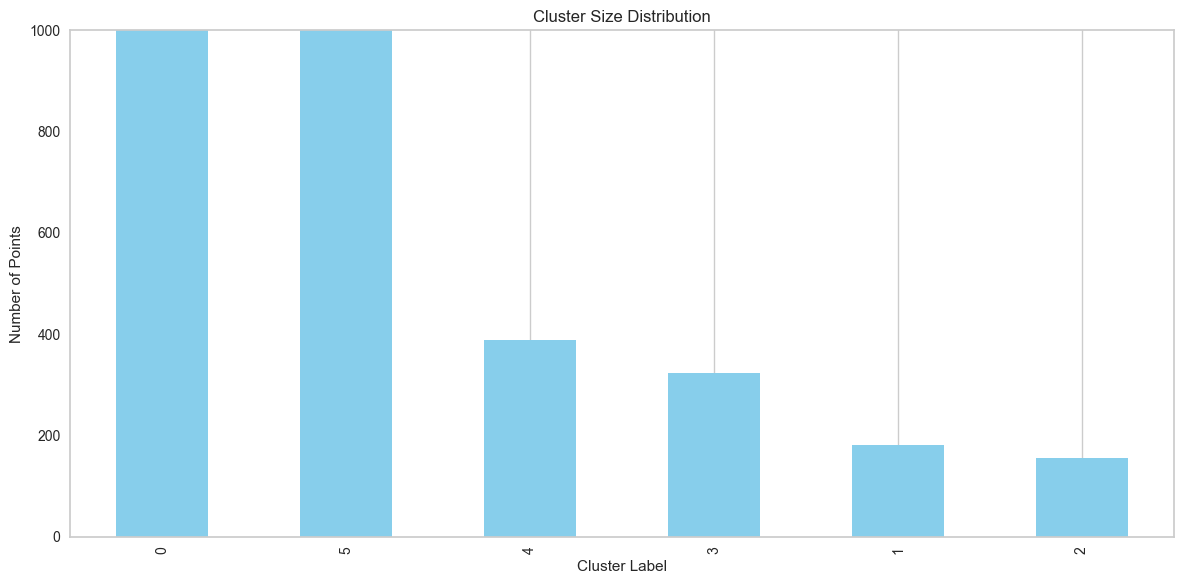

In [59]:
cluster_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.ylim(0, 1000)  
plt.grid(axis='y')
plt.tight_layout()
plt.show()

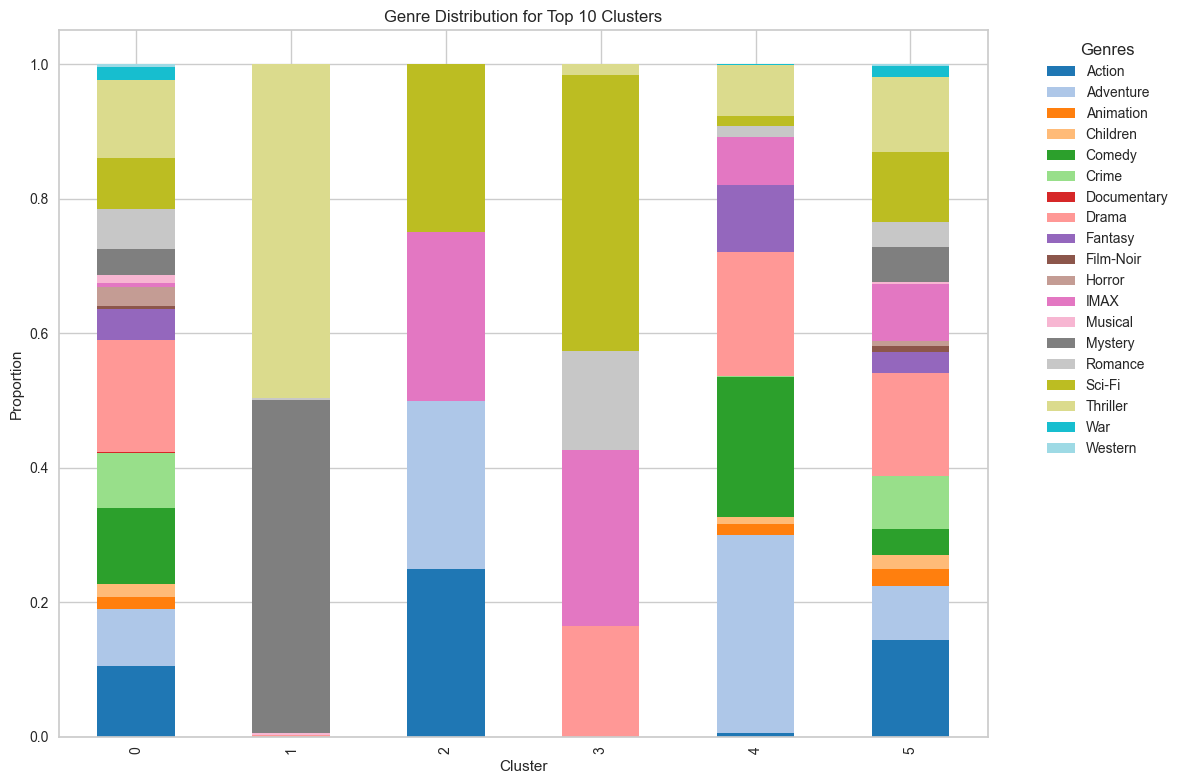

In [54]:
df_exploded = df_sampled.copy()
df_exploded['genres'] = df_exploded['genres'].str.split('|')
df_exploded = df_exploded.explode('genres')

genre_distribution = df_exploded.groupby(['cluster', 'genres']).size().unstack(fill_value=0)
genre_distribution = genre_distribution.div(genre_distribution.sum(axis=1), axis=0)

genre_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Genre Distribution for Top 10 Clusters')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

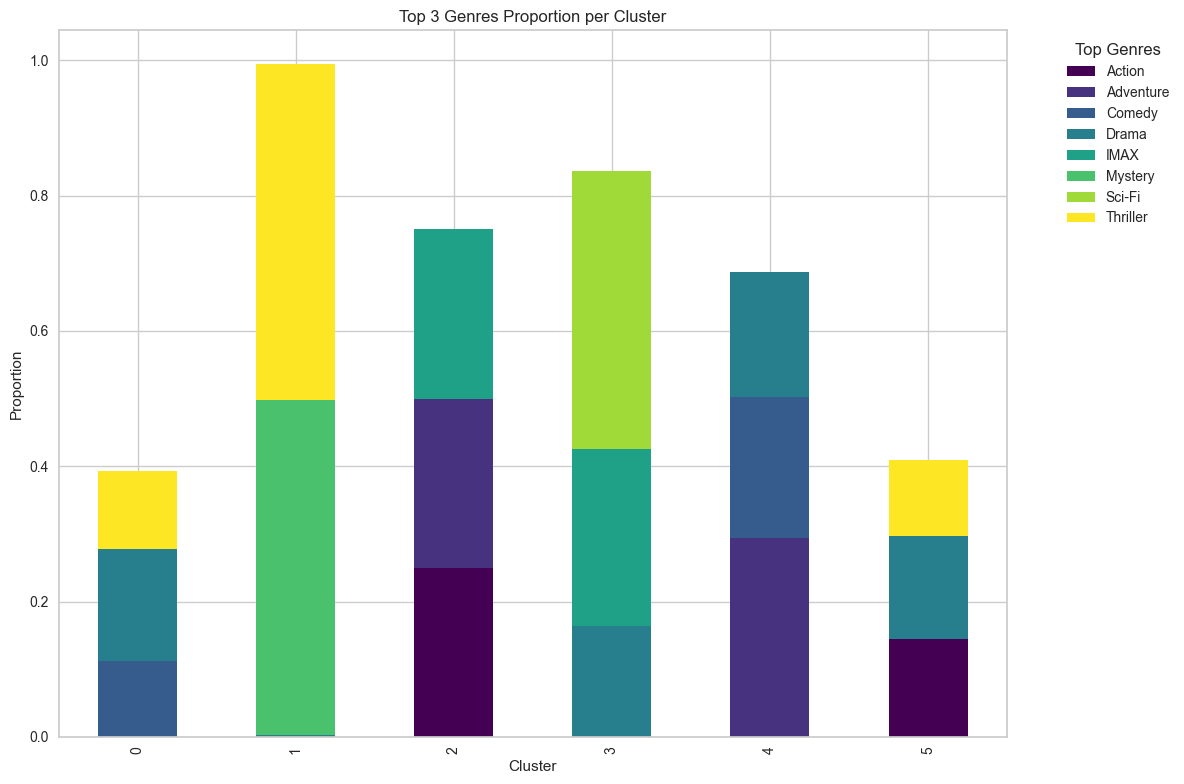

In [55]:
top_genres_proportions = genre_distribution.apply(lambda x: x.nlargest(3), axis=1)

top_genres_proportions.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Top 3 Genres Proportion per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Top Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

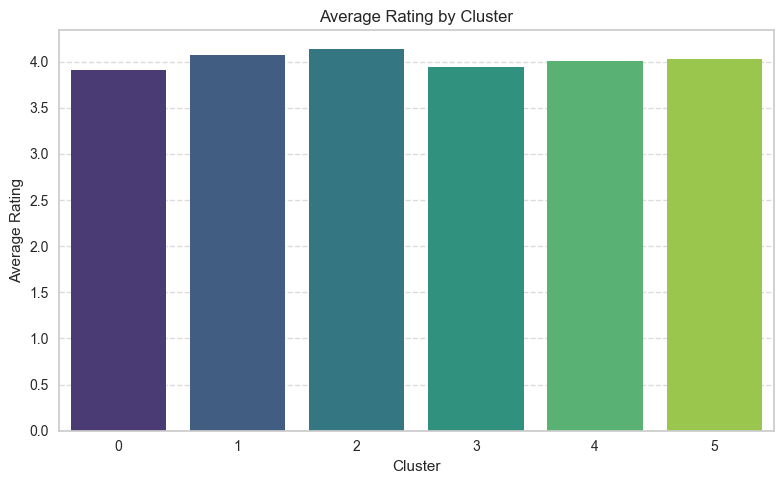

In [61]:
avg_ratings = df_sampled[df_sampled['cluster'] != -1].groupby('cluster')['rating'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_ratings, x='cluster', y='rating', palette='viridis')
plt.title("Average Rating by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Rating")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/4z/dn0sxmcn6lzf0n6lfw2mgfx80000gn/T/ipykernel_49574/2540363098.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'count'))


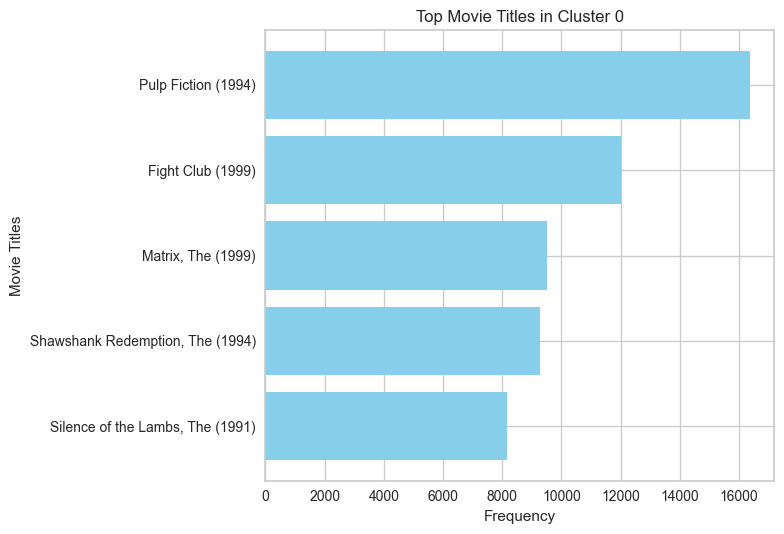

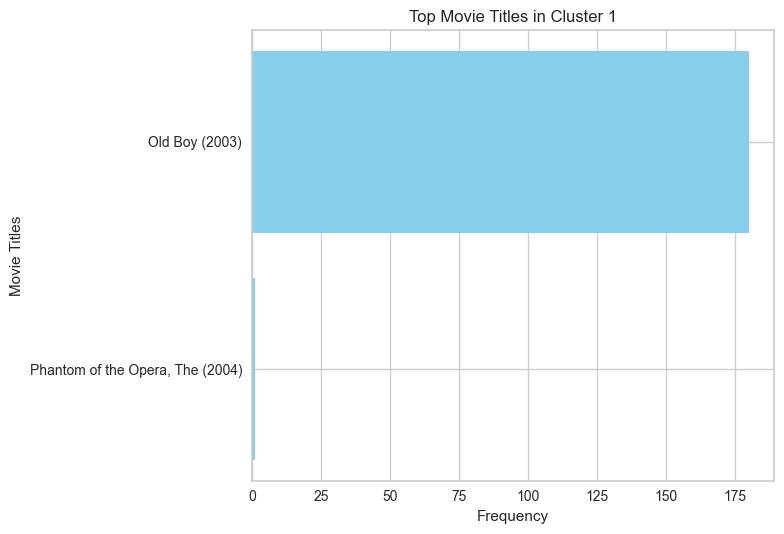

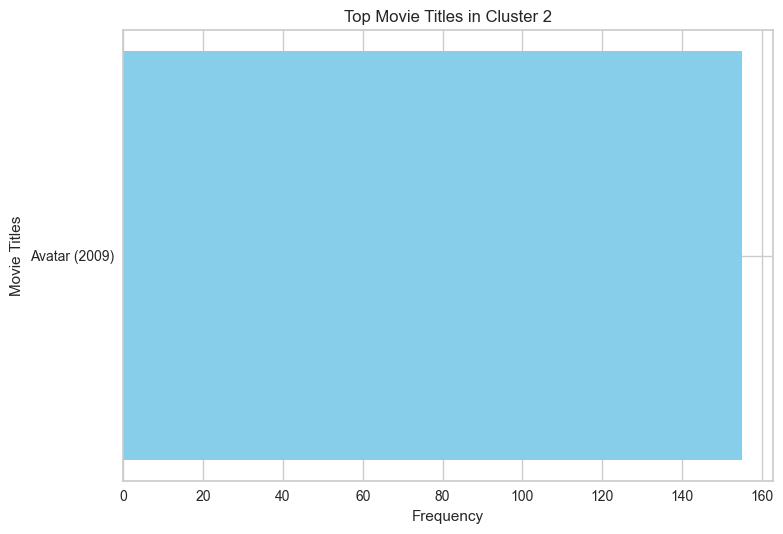

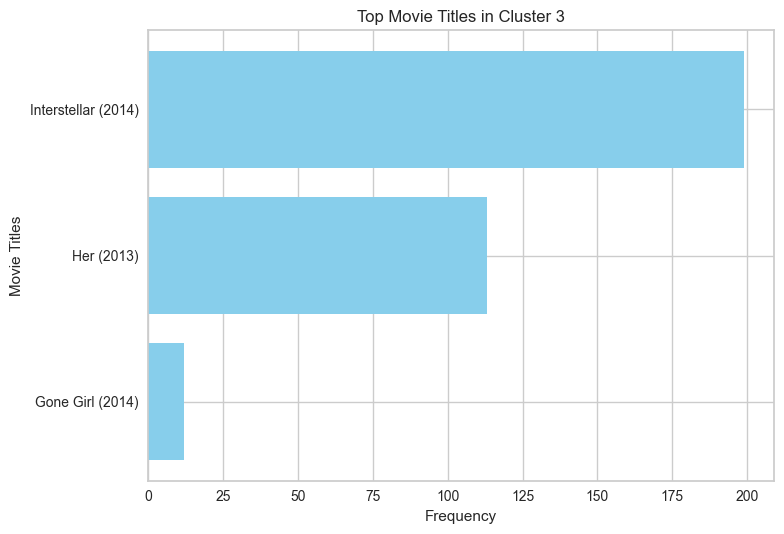

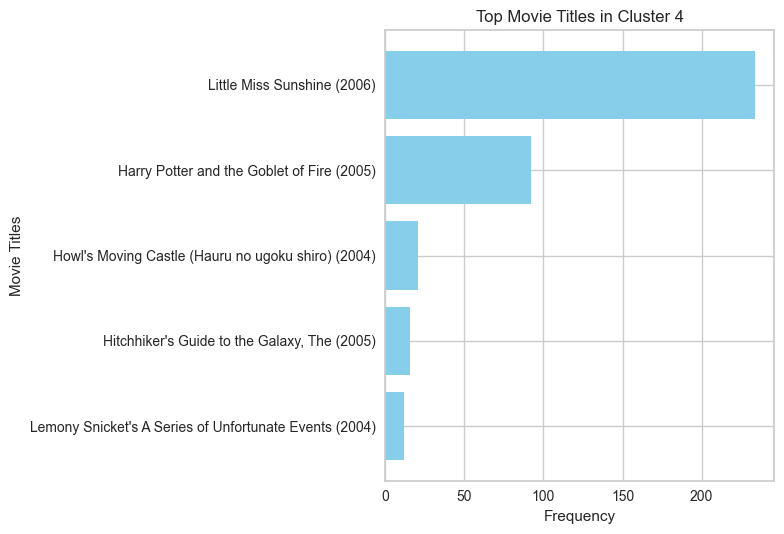

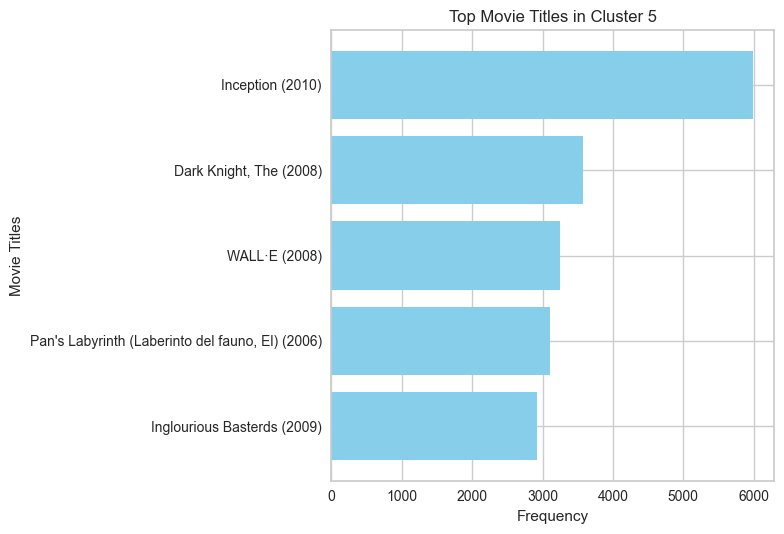

In [62]:
top_titles_by_cluster = df_sampled.groupby(['cluster', 'title']).size().reset_index(name='count')
top_titles_by_cluster = top_titles_by_cluster[top_titles_by_cluster['cluster'] != -1]

top_titles_by_cluster = (
    top_titles_by_cluster.groupby('cluster', group_keys=False)
    .apply(lambda x: x.nlargest(5, 'count'))
)

for cluster in top_titles_by_cluster['cluster'].unique():
    cluster_data = top_titles_by_cluster[top_titles_by_cluster['cluster'] == cluster]

    plt.barh(cluster_data['title'], cluster_data['count'], color='skyblue')
    plt.title(f'Top Movie Titles in Cluster {cluster}')
    plt.xlabel('Frequency')
    plt.ylabel('Movie Titles')
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

In [65]:
df_sampled

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,cluster
2626920,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,18192,3.5,1375031072,86485,crime,1254166154,0
5286052,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,49830,5.0,1129741143,2248,adventure,1151067195,0
13405543,8622,Fahrenheit 9/11 (2004),Documentary,8932,4.5,1219336350,88738,US President,1308071837,0
15060974,46976,Stranger than Fiction (2006),Comedy|Drama|Fantasy|Romance,63200,3.5,1206202078,130446,love,1335658378,5
8801706,2959,Fight Club (1999),Action|Crime|Drama|Thriller,99477,4.5,1241120533,14947,adapted from:book,1283594616,0
...,...,...,...,...,...,...,...,...,...,...
14119570,32587,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller,119746,3.0,1326970849,27898,stylized,1268432477,-1
10172248,4226,Memento (2000),Mystery|Thriller,91973,3.5,1386920449,49129,nonlinear,1303944377,0
12909228,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,33871,5.0,1403463952,11081,stylized,1172055602,0
8429040,2858,American Beauty (1999),Comedy|Drama,113940,5.0,1156032272,11081,biting,1171184183,0


same as before but I had to define the df into two seperate halves, due to the cluster sizes

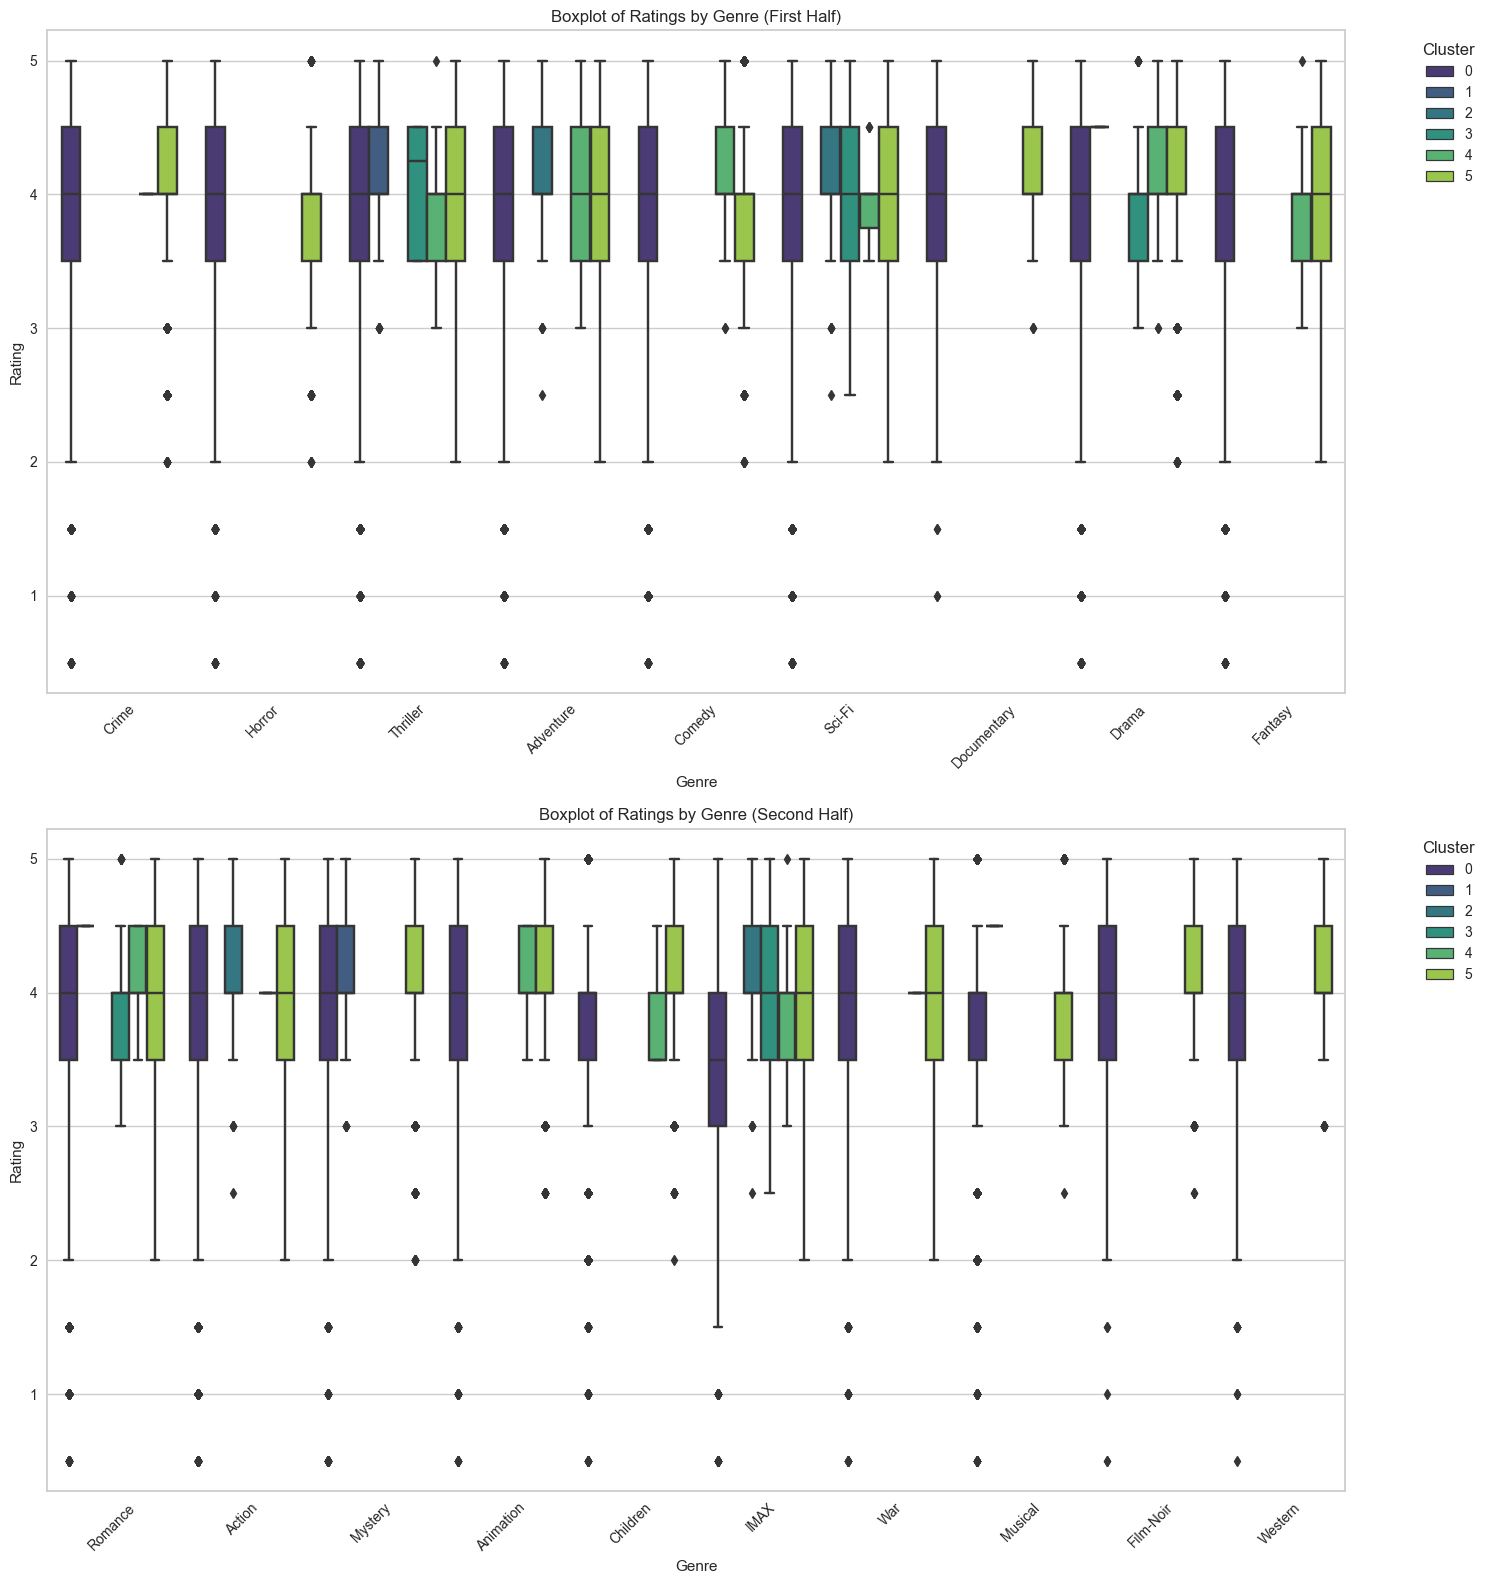

In [69]:
df_exploded = df_exploded[df_exploded['cluster'] != -1]

unique_genres = df_exploded['genres'].unique()
half = len(unique_genres) // 2
genres_first_half = unique_genres[:half]
genres_second_half = unique_genres[half:]

data_first_half = df_exploded[df_exploded['genres'].isin(genres_first_half)]
data_second_half = df_exploded[df_exploded['genres'].isin(genres_second_half)]

fig, axes = plt.subplots(2, 1, figsize=(15, 16), sharey=True)

sns.boxplot(
    x='genres', y='rating', hue='cluster', data=data_first_half, ax=axes[0], palette='viridis'
)
axes[0].set_title('Boxplot of Ratings by Genre (First Half)')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Rating')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.boxplot(
    x='genres', y='rating', hue='cluster', data=data_second_half, ax=axes[1], palette='viridis'
)
axes[1].set_title('Boxplot of Ratings by Genre (Second Half)')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Rating')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## Fuzzy C means

In [ ]:
sample_size = 1000000
np.random.seed(0)
X_sample = np.random.choice(reduced_data.shape[0], sample_size, replace=False)
subset_data = reduced_data[X_sample]

In [24]:
subset_data = pd.DataFrame(subset_data)
data_for_fcm = subset_data.values  

cntr, u, u0, d, jm, p, fpc = cmeans(
    data_for_fcm.T,  
    c = 20,  
    m = 1.5,
    error = 0.005,
    maxiter = 1000,
    init = None,
)

cluster_membership = np.argmax(u, axis=0)
subset_data['cluster'] = cluster_membership  

print(f"Cluster centers:\n{cntr}")
print(f"Cluster labels assigned to data:\n{subset_data['cluster'].value_counts()}")

Cluster centers:
[[-9.78427784e-01 -3.35818480e-01 -3.90443251e-01 -6.22329304e-02
  -5.42576478e-01 -3.33751177e-01  2.32094992e-01  1.52860652e-01
   2.19150917e-01  1.27960303e+01]
 [-2.90513828e-01 -7.16675502e-01 -2.41870840e-01 -7.24415794e-01
  -2.80240860e-01 -3.10473926e-01 -4.28245650e-02  5.38284419e-02
  -1.91649847e-01  1.93689337e+00]
 [-7.13778886e-01 -4.76179484e-01  4.78695924e-02 -1.30532027e-01
  -2.20393468e-01  4.87205380e-02 -2.73779047e-01  2.24799876e-02
   2.24118769e-01  1.27571178e+01]
 [ 2.94838823e-01 -1.07191169e-01  1.77785026e-01  3.23641147e-01
  -1.19098152e-02  2.53734161e-01 -1.59497896e-01  5.32043817e-02
  -2.58816213e-01  7.99932905e+00]
 [-2.51351700e-02  3.81765936e-01 -2.07079247e-01 -3.51715941e-02
   1.92464742e-01  2.42509792e-01 -1.77672103e-02 -5.38242603e-02
  -2.24856637e-01  7.26949589e+00]
 [ 2.27666483e+00  1.78514932e-01 -5.68533426e-01 -4.66351504e-01
  -2.32186983e-02 -2.73659291e-01  2.96252992e-01  2.38536425e-01
   9.14752040e-0

/var/folders/4z/dn0sxmcn6lzf0n6lfw2mgfx80000gn/T/ipykernel_60911/748434358.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['cluster'] = cluster_membership


In [23]:
sample_size = 100000
np.random.seed(0) 

sampled_indices = np.random.choice(subset_data.shape[0], sample_size, replace=False)
sampled_data = subset_data.iloc[sampled_indices]
sampled_labels = cluster_membership[sampled_indices]

silhouette_fcm = silhouette_score(sampled_data.values, sampled_labels)
print(f"Silhouette Score for Fuzzy C-Means (Sampled 100,000 points): {silhouette_fcm}")

Silhouette Score for Fuzzy C-Means (Sampled 100,000 points): 0.10244842955099816


### Cluster Analysis

In [25]:
df_sampled_2 = df.iloc[X_sample].copy()
df_sampled_2['cluster'] = cluster_membership

In [10]:
df_sampled_2

,movieId,title,genres,userId_x,rating,timestamp_x,userId_y,tag,timestamp_y,cluster
2626920,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,18192,3.5,1375031072,86485,crime,1254166154,2
5286052,1270,Back to the Future (1985),Adventure|Comedy|Sci-Fi,49830,5.0,1129741143,2248,adventure,1151067195,8
13405543,8622,Fahrenheit 9/11 (2004),Documentary,8932,4.5,1219336350,88738,US President,1308071837,4
15060974,46976,Stranger than Fiction (2006),Comedy|Drama|Fantasy|Romance,63200,3.5,1206202078,130446,love,1335658378,2
8801706,2959,Fight Club (1999),Action|Crime|Drama|Thriller,99477,4.5,1241120533,14947,adapted from:book,1283594616,7
...,...,...,...,...,...,...,...,...,...,...
14119570,32587,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller,119746,3.0,1326970849,27898,stylized,1268432477,0
10172248,4226,Memento (2000),Mystery|Thriller,91973,3.5,1386920449,49129,nonlinear,1303944377,0
12909228,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,33871,5.0,1403463952,11081,stylized,1172055602,9
8429040,2858,American Beauty (1999),Comedy|Drama,113940,5.0,1156032272,11081,biting,1171184183,5


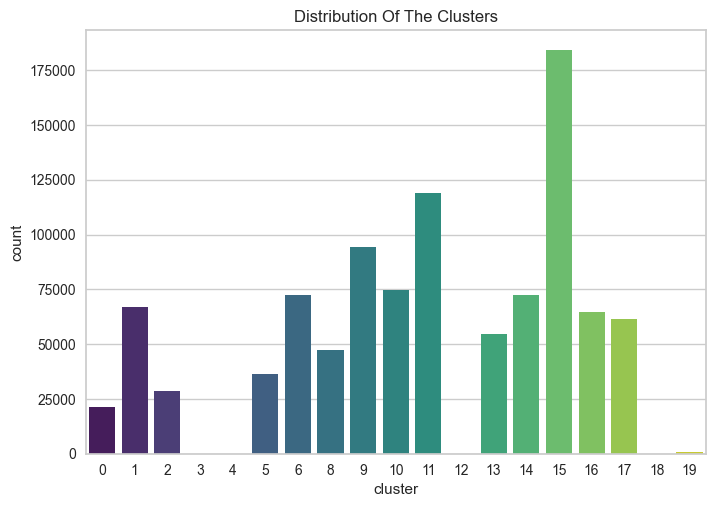

In [26]:
pl = sns.countplot(x=df_sampled_2["cluster"], palette='viridis')
pl.set_title("Distribution Of The Clusters")
plt.show()

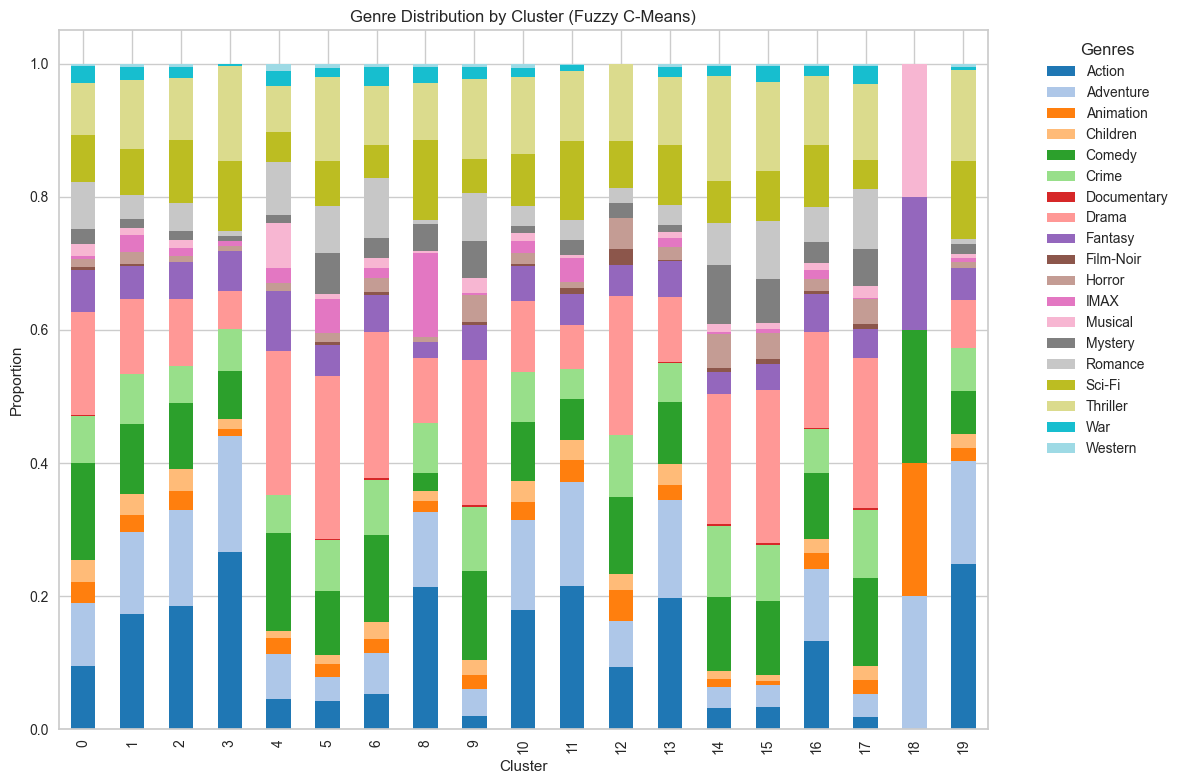

In [27]:
df_exploded = df_sampled_2.copy()
df_exploded['genres'] = df_exploded['genres'].str.split('|')
df_exploded = df_exploded.explode('genres')

genre_distribution = df_exploded.groupby(['cluster', 'genres']).size().unstack(fill_value=0)
genre_distribution = genre_distribution.div(genre_distribution.sum(axis=1), axis=0)  

genre_distribution.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Genre Distribution by Cluster (Fuzzy C-Means)')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

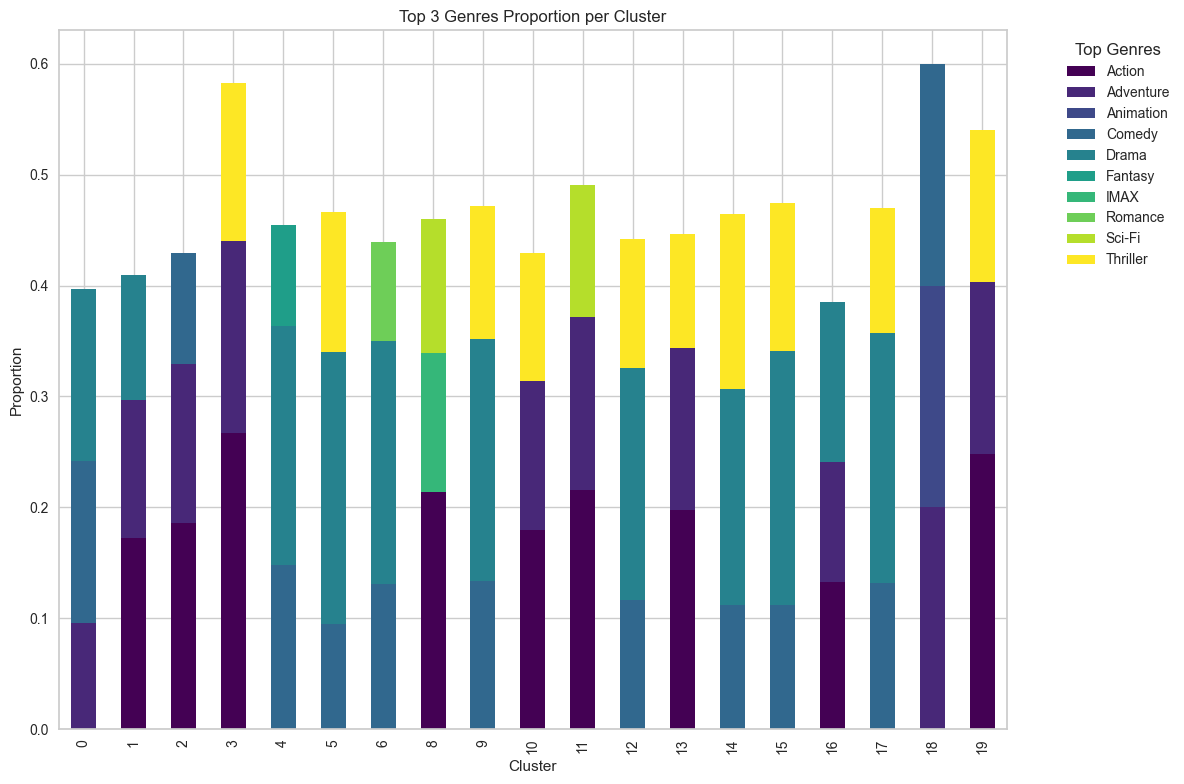

In [28]:
top_genres_proportions = genre_distribution.apply(lambda x: x.nlargest(3), axis=1)

top_genres_proportions.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Top 3 Genres Proportion per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Top Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

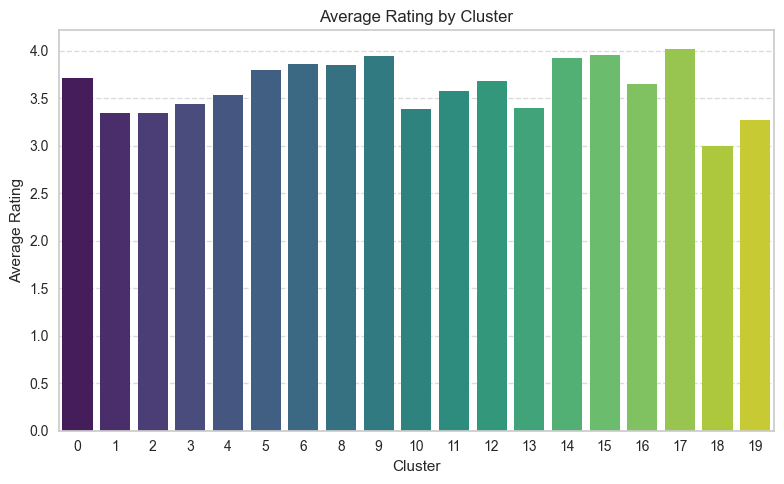

In [29]:
avg_ratings = df_sampled_2.groupby('cluster')['rating'].mean().reset_index()

top_10_cluster_data = df_sampled_2[df_sampled_2['cluster'].isin(df_sampled_2)].copy()

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_ratings, x='cluster', y='rating', palette='viridis')
plt.title("Average Rating by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Rating")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/var/folders/4z/dn0sxmcn6lzf0n6lfw2mgfx80000gn/T/ipykernel_60911/3352645886.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'count'))


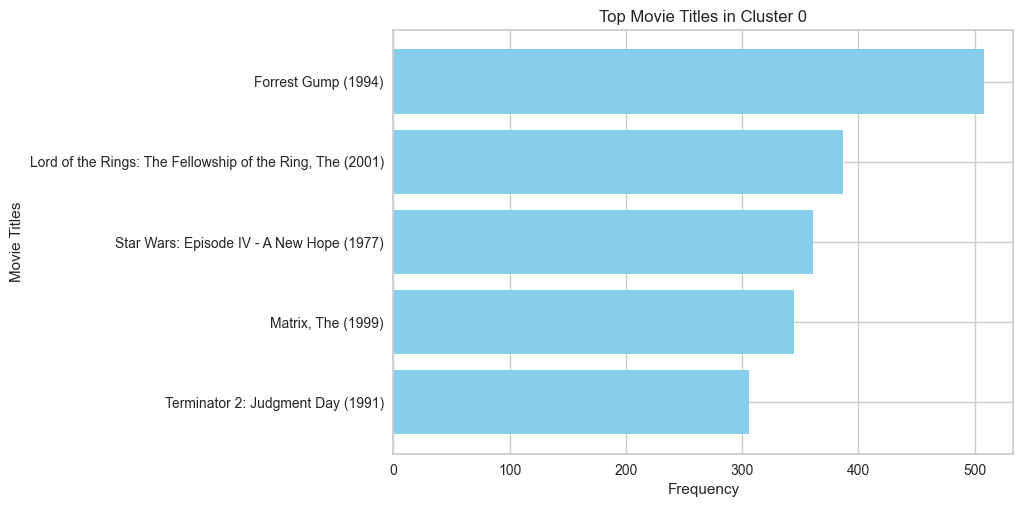

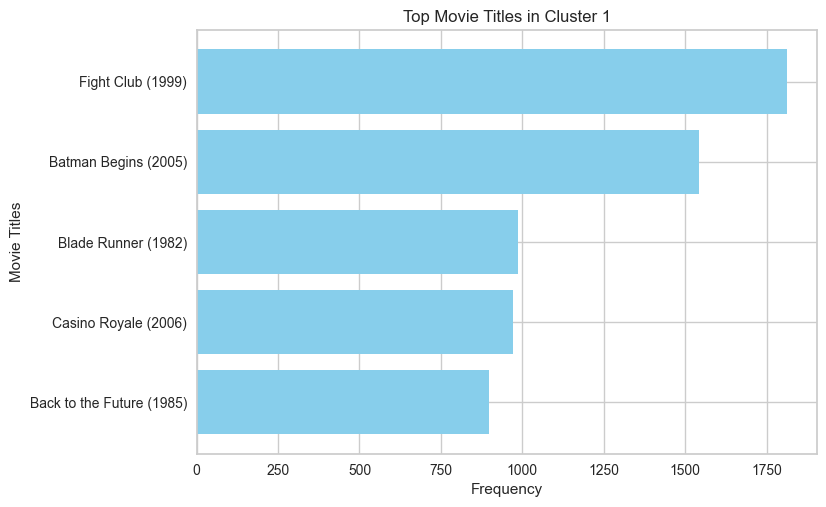

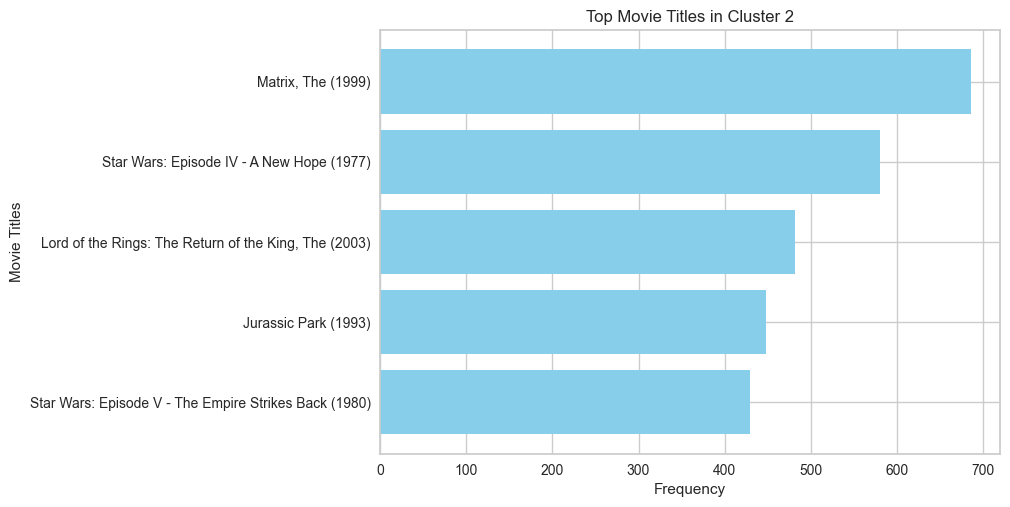

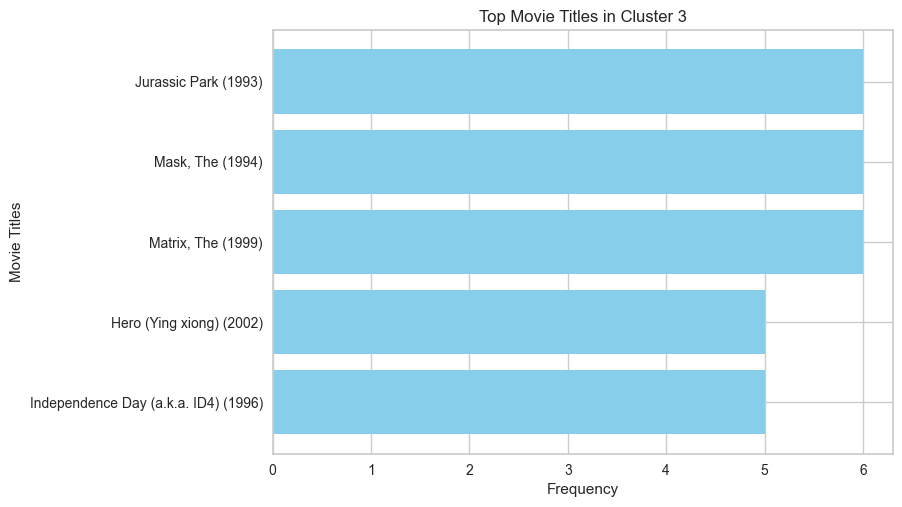

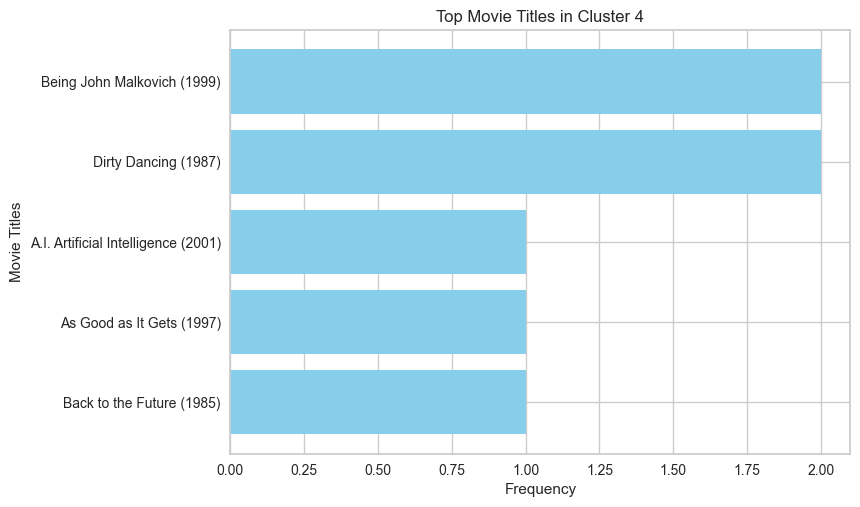

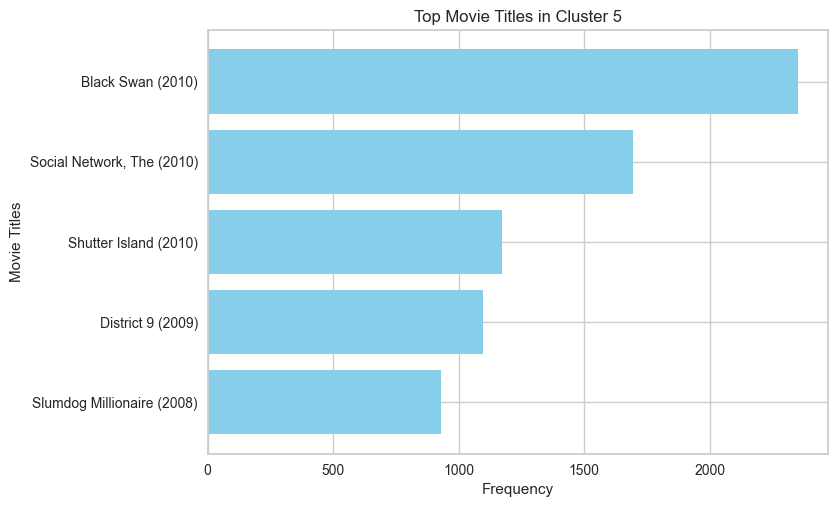

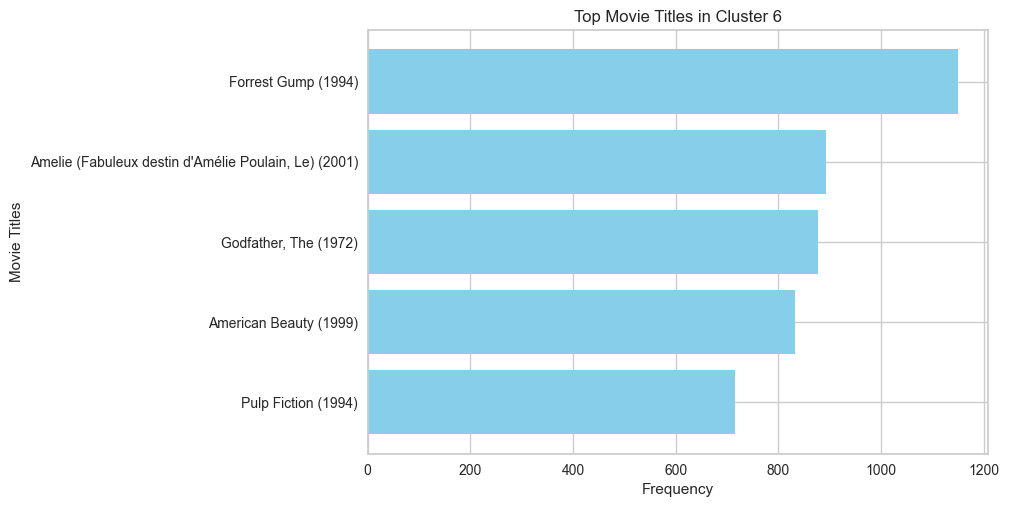

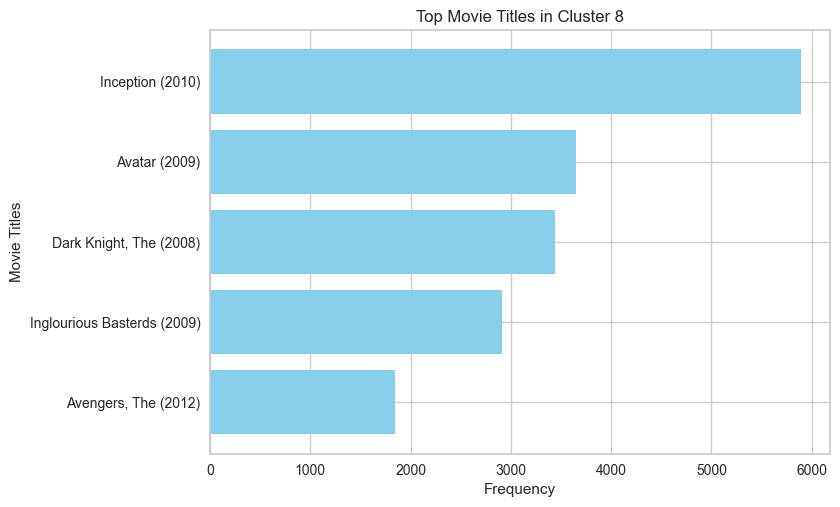

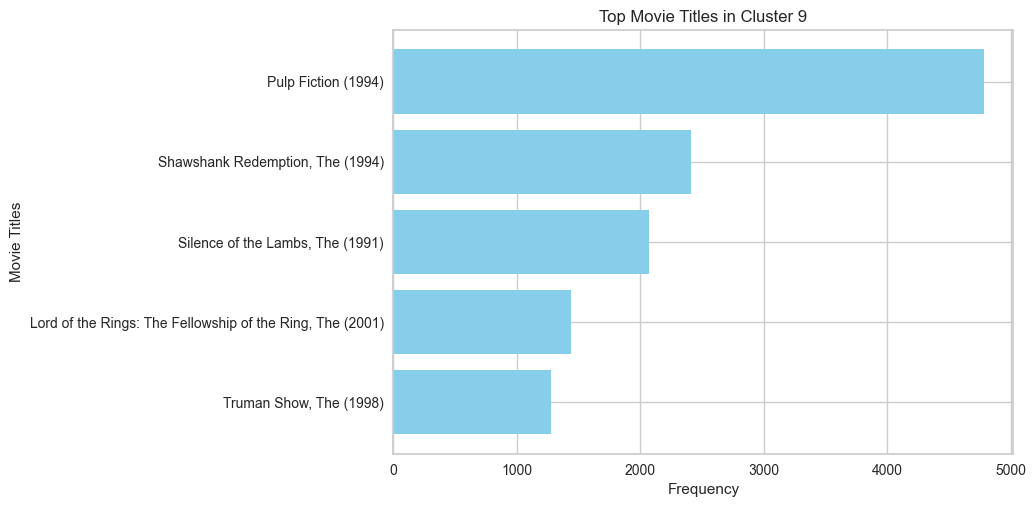

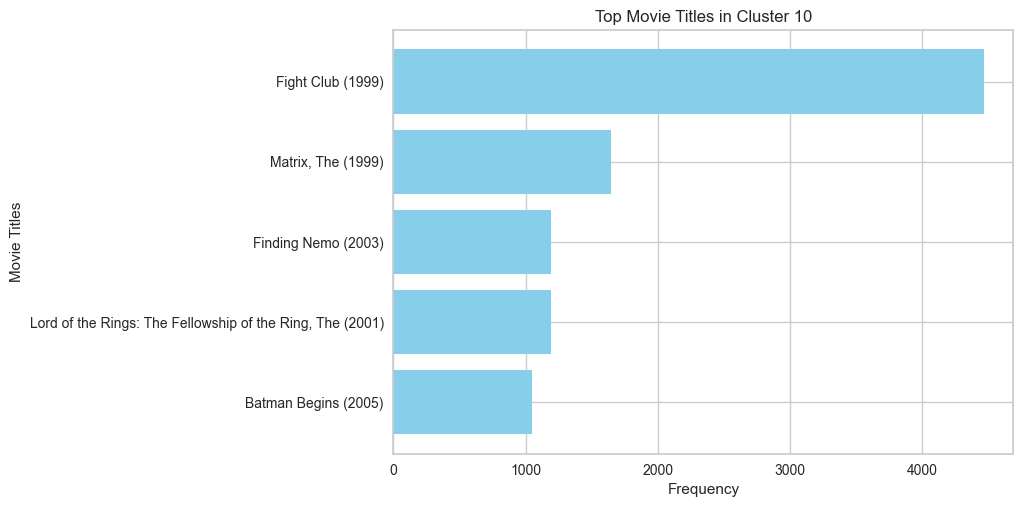

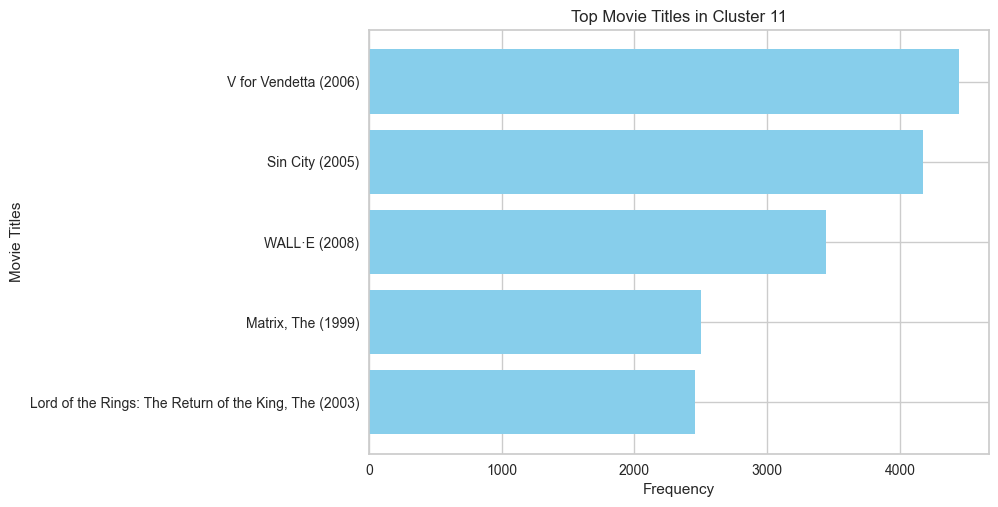

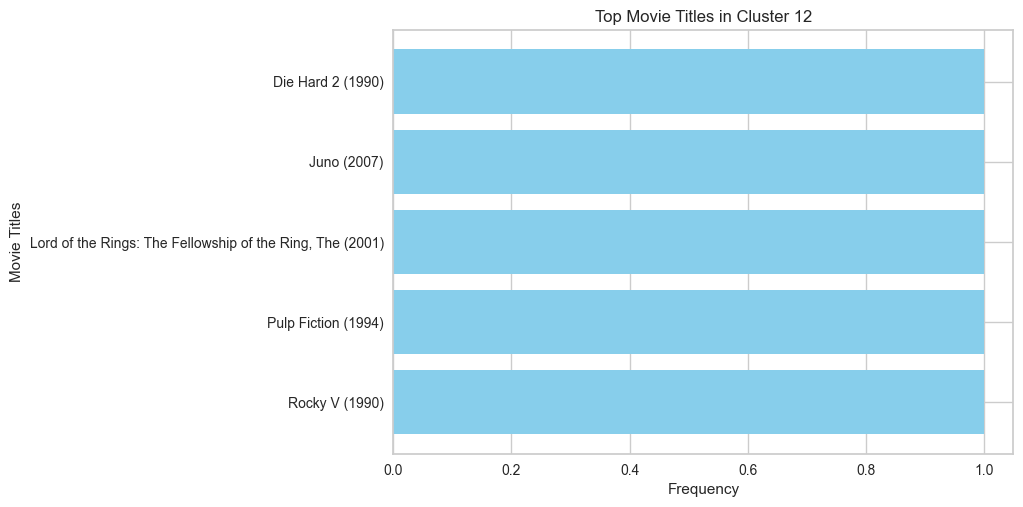

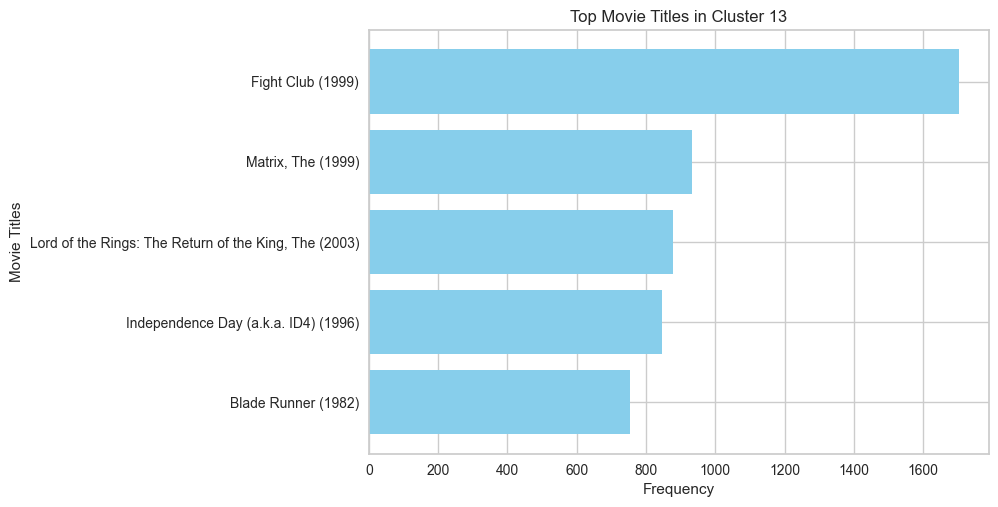

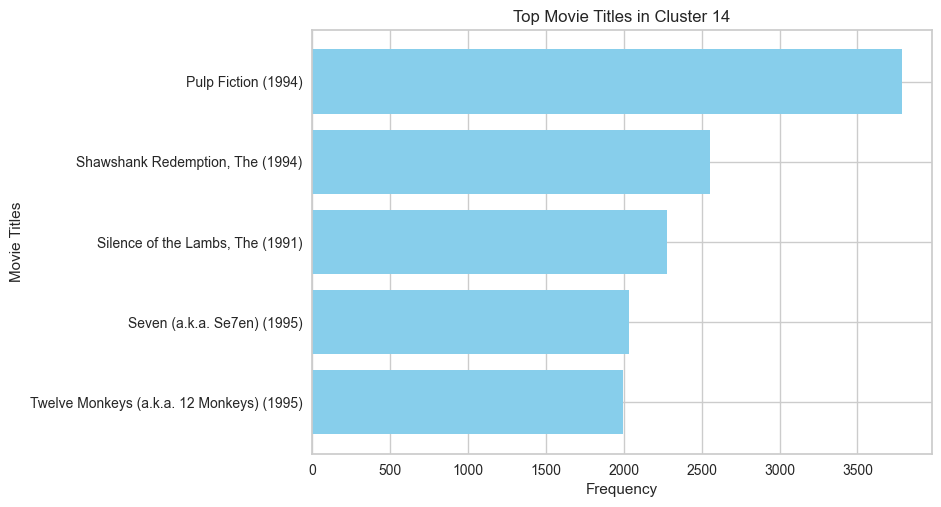

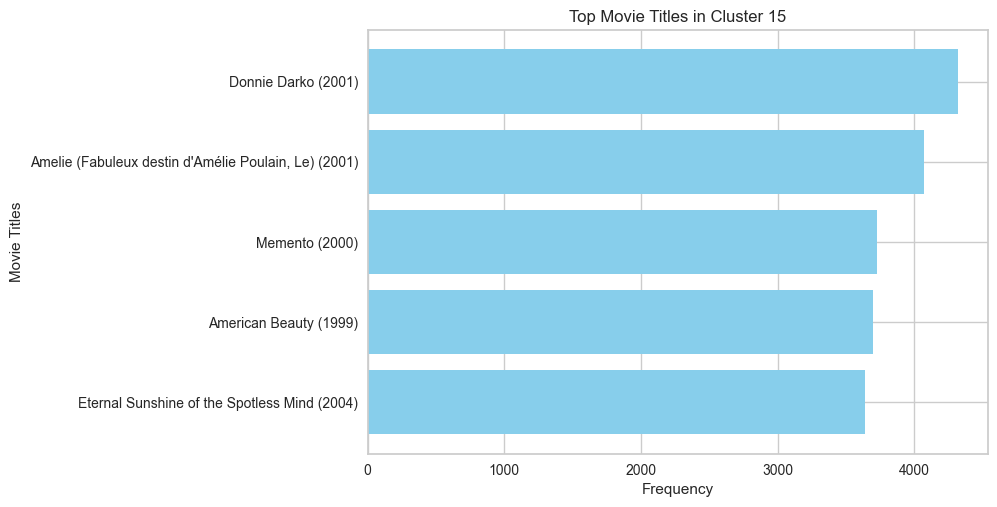

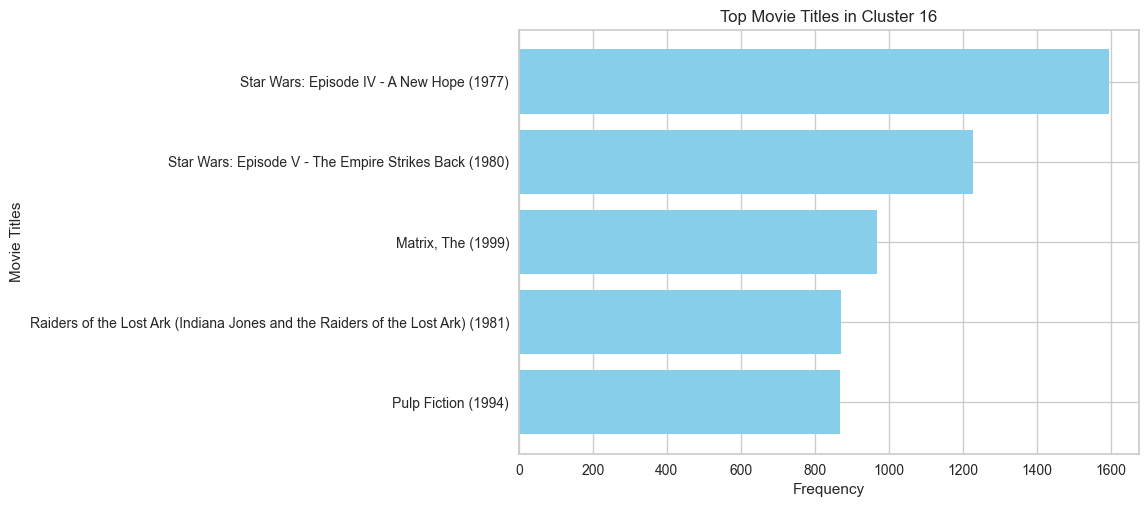

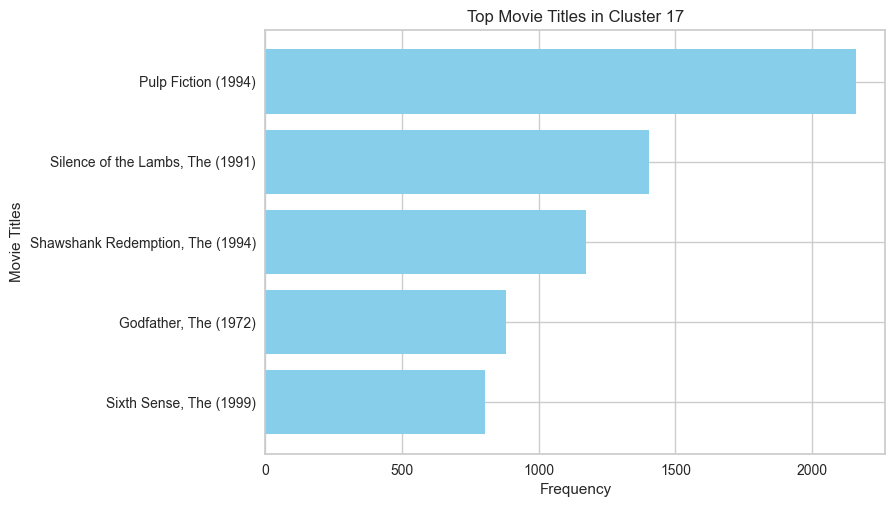

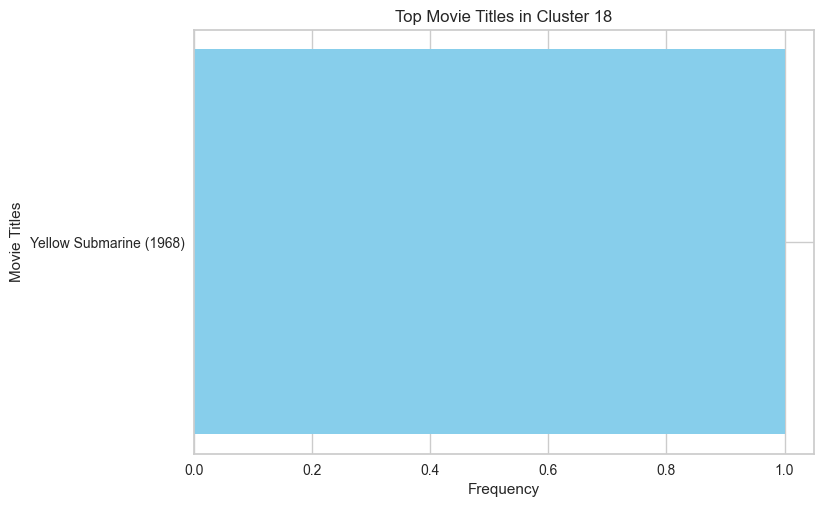

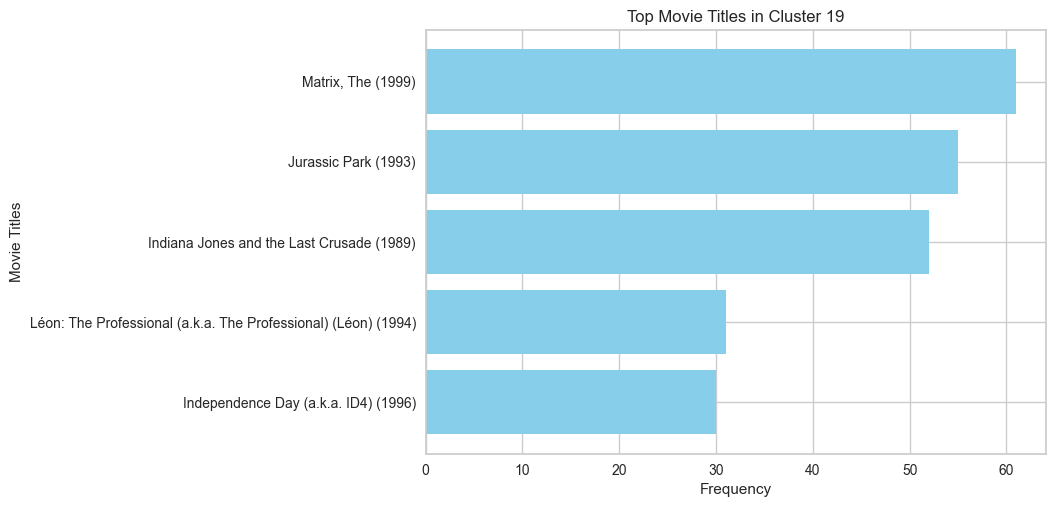

In [30]:
top_titles_by_cluster = df_sampled_2.groupby(['cluster', 'title']).size().reset_index(name='count')

top_titles_by_cluster = (
    top_titles_by_cluster.groupby('cluster', group_keys=False)
    .apply(lambda x: x.nlargest(5, 'count'))
)

for cluster in top_titles_by_cluster['cluster'].unique():
    cluster_data = top_titles_by_cluster[top_titles_by_cluster['cluster'] == cluster]
    plt.barh(cluster_data['title'], cluster_data['count'], color='skyblue')
    plt.title(f'Top Movie Titles in Cluster {cluster}')
    plt.xlabel('Frequency')
    plt.ylabel('Movie Titles')
    plt.gca().invert_yaxis()
    plt.show()

same as before but this time I had to define the df into four quarters due to the cluster sizes

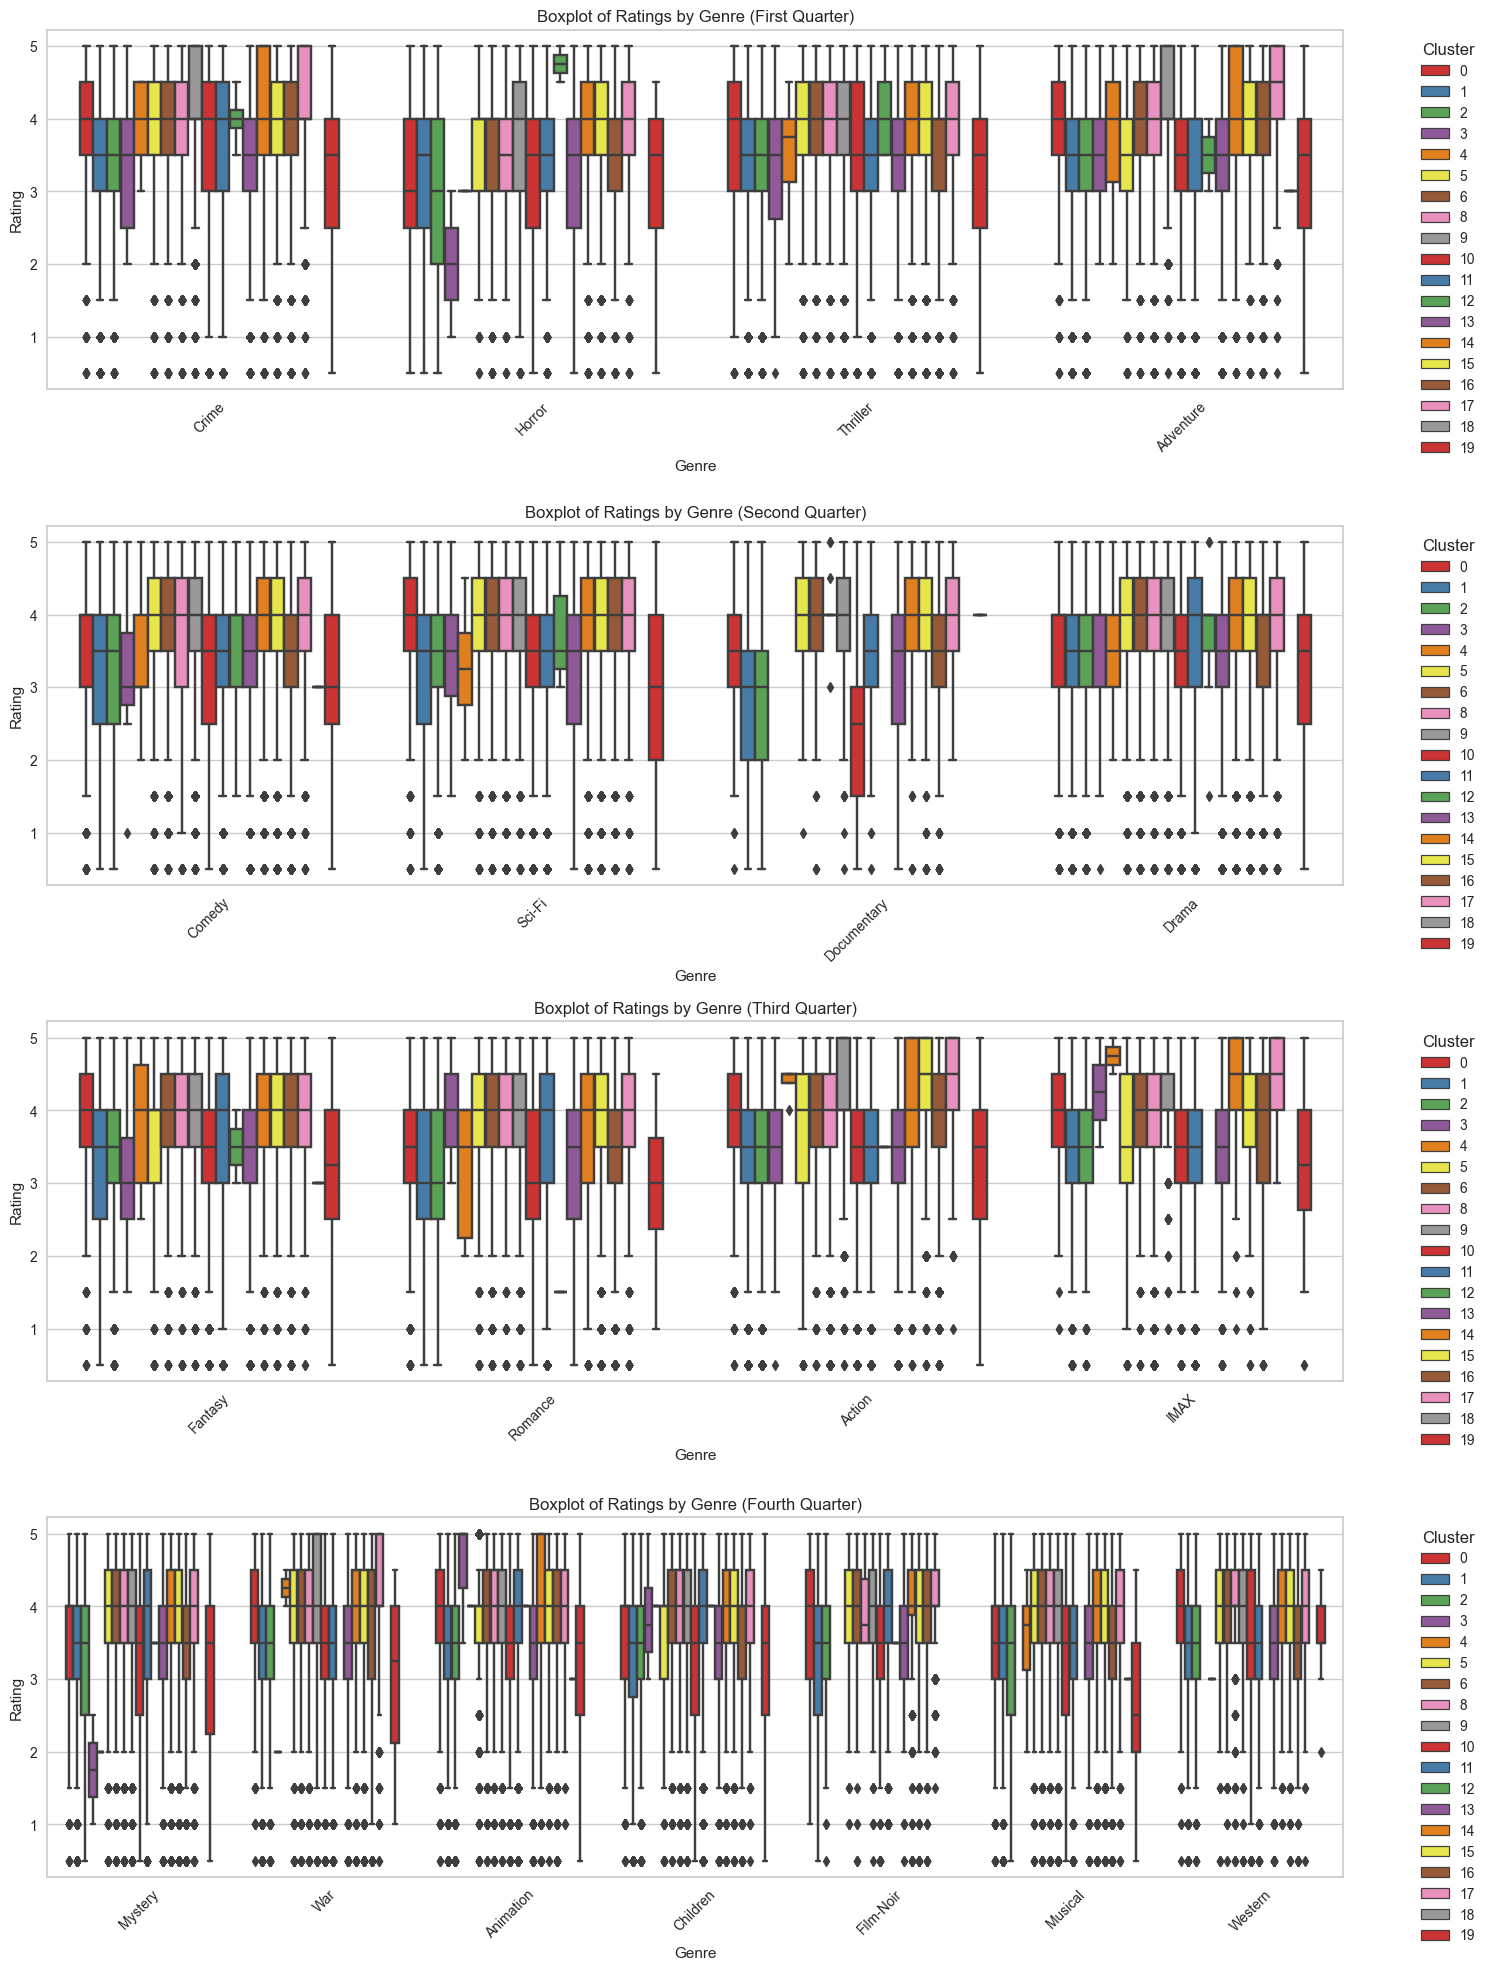

In [36]:
unique_genres = df_exploded['genres'].unique()
quarter = len(unique_genres) // 4

genres_first_quarter = unique_genres[:quarter]
genres_second_quarter = unique_genres[quarter:2*quarter]
genres_third_quarter = unique_genres[2*quarter:3*quarter]
genres_fourth_quarter = unique_genres[3*quarter:]

data_first_quarter = df_exploded[df_exploded['genres'].isin(genres_first_quarter)]
data_second_quarter = df_exploded[df_exploded['genres'].isin(genres_second_quarter)]
data_third_quarter = df_exploded[df_exploded['genres'].isin(genres_third_quarter)]
data_fourth_quarter = df_exploded[df_exploded['genres'].isin(genres_fourth_quarter)]

fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharey=True)

sns.boxplot(
    x='genres', y='rating', hue='cluster', data=data_first_quarter, ax=axes[0], palette='Set1'
)
axes[0].set_title('Boxplot of Ratings by Genre (First Quarter)')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Rating')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.boxplot(
    x='genres', y='rating', hue='cluster', data=data_second_quarter, ax=axes[1], palette='Set1'
)
axes[1].set_title('Boxplot of Ratings by Genre (Second Quarter)')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Rating')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.boxplot(
    x='genres', y='rating', hue='cluster', data=data_third_quarter, ax=axes[2], palette='Set1'
)
axes[2].set_title('Boxplot of Ratings by Genre (Third Quarter)')
axes[2].set_xlabel('Genre')
axes[2].set_ylabel('Rating')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.boxplot(
    x='genres', y='rating', hue='cluster', data=data_fourth_quarter, ax=axes[3], palette='Set1'
)
axes[3].set_title('Boxplot of Ratings by Genre (Fourth Quarter)')
axes[3].set_xlabel('Genre')
axes[3].set_ylabel('Rating')
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()